<a href="https://colab.research.google.com/github/mjojic/Portfolio/blob/main/SegFormer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.2 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision.ops import StochasticDepth
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.init as init
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from einops import rearrange
from typing import List
import numpy as np

In [ ]:
data_transforms = [
    transforms.Resize((128, 128)),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # Scales data into [0,1]
    #transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
    ]
data_transform = transforms.Compose(data_transforms)



mask_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: torch.stack([F.one_hot(torch.round(im/0.0039 - 1).to(torch.int64), num_classes = 3).permute(2, 0, 1).float() for im in t], dim=0).squeeze(1))
    #transforms.Lambda(lambda t: torch.stack([F.one_hot(im.to(torch.int64), num_classes = 2).permute(2, 0, 1).float() for im in t], dim=0).squeeze(1))
])

train = torchvision.datasets.OxfordIIITPet(root=".", split = 'trainval', download = True, target_types = 'segmentation', transform=data_transform, target_transform=mask_transforms)

#train = torchvision.datasets.VOCSegmentation(root=".", image_set = 'train', download = True, transform=data_transform, target_transform=mask_transforms)

#test = torchvision.datasets.OxfordIIITPet(root=".", train = False, download=True, transform=data_transform,target_transform=mask_transforms)

train_loader = DataLoader(train, batch_size=64, shuffle=True)

100%|██████████| 791918971/791918971 [00:49<00:00, 15857654.56it/s]


Extracting oxford-iiit-pet/images.tar.gz to oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:02<00:00, 7233989.76it/s] 


Extracting oxford-iiit-pet/annotations.tar.gz to oxford-iiit-pet


In [ ]:
class LayerNorm2d(nn.LayerNorm):
  def forward(self, x):
    x = rearrange(x, "b c h w -> b h w c")
    x = super().forward(x)
    x = rearrange(x, "b h w c -> b c h w")
    return x

class OverlapPatchMerging(nn.Module):
  def __init__(self, in_channels, out_channels, patch_size, overlap_size):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = patch_size, stride = overlap_size, padding = patch_size // 2, bias = False)
    self.layer_norm = LayerNorm2d(out_channels)

  def forward(self, x):
    x = self.conv(x)
    x = self.layer_norm(x)
    return x

class EfficientMultiHeadAttention(nn.Module):
  def __init__(self, channels, reduction_ratio, num_heads = 8):
    super().__init__()
    self.reducer = nn.Sequential(
        nn.Conv2d(channels, channels, kernel_size = reduction_ratio, stride = reduction_ratio),
        LayerNorm2d(channels)
    )
    self.attention = nn.MultiheadAttention(channels, num_heads = num_heads, batch_first = True)

  def forward(self, x):
    _, _, h, w = x.shape
    reduced_x = self.reducer(x)
    reduced_x = rearrange(reduced_x, "b c h w -> b (h w) c")
    x = rearrange(x, "b c h w -> b (h w) c")
    out = self.attention(x, reduced_x, reduced_x)[0]
    out = rearrange(out, "b (h w) c -> b c h w", h = h, w = w)
    return out

class MixMLP(nn.Module):
  def __init__(self, channels, expansion = 4):
    super().__init__()
    self.conv_1 = nn.Conv2d(channels, channels, kernel_size = 1)
    self.conv_2 = nn.Conv2d(channels, channels * expansion, kernel_size = 3, groups = channels, padding = 1)
    self.gelu = nn.GELU()
    self.conv_3 = nn.Conv2d(channels * expansion, channels, kernel_size = 1)

  def forward(self, x):
    x = self.conv_1(x)
    x = self.conv_2(x)
    x = self.gelu(x)
    x = self.conv_3(x)
    return x

class ResidualAdd(nn.Module):
  def __init__(self, fn):
    super().__init__()
    self.fn = fn

  def forward(self, x, **kwargs):
    out = self.fn(x, **kwargs)
    x = x + out
    return x

def chunks(data, sizes):
  curr = 0
  for size in sizes:
    chunk = data[curr: curr + size]
    curr += size
    yield chunk

In [ ]:
class SegFormerEncoderBlock(nn.Module):
  def __init__(self, channels, reduction_ratio = 1, num_heads = 8, mlp_expansion = 4, drop_path_prob = 0.0):
    super().__init__()
    self.layer_1 = ResidualAdd(nn.Sequential(
        LayerNorm2d(channels),
        EfficientMultiHeadAttention(channels, reduction_ratio, num_heads),
    ))
    self.layer_2 = ResidualAdd(nn.Sequential(
        LayerNorm2d(channels),
        MixMLP(channels, expansion = mlp_expansion),
        StochasticDepth(p = drop_path_prob, mode = "batch")
    ))
  def forward(self, x):
    x = self.layer_1(x)
    x = self.layer_2(x)
    return x

class SegFormerEncoderStage(nn.Module):
  def __init__(self, in_channels, out_channels, patch_size, overlap_size, drop_probs, depth = 2, reduction_ratio = 1, num_heads = 8, mlp_expansion = 4):
    super().__init__()
    self.overlap_patch_merge = OverlapPatchMerging(in_channels, out_channels, patch_size, overlap_size)
    self.blocks = nn.Sequential(
        *[
            SegFormerEncoderBlock(out_channels, reduction_ratio, num_heads, mlp_expansion, drop_probs[i]) for i in range(depth)
        ]
    )
    self.norm = LayerNorm2d(out_channels)

  def forward(self, x):
    x = self.overlap_patch_merge(x)
    x = self.blocks(x)
    x = self.norm(x)
    return x

class SegFormerEncoder(nn.Module):
  def __init__(self, in_channels, widths, depths, all_num_heads, patch_sizes, overlap_sizes, reduction_ratios, mlp_expansions, drop_prob = .0):
    super().__init__()
    drop_probs = [x.item() for x in torch.linspace(0, drop_prob, sum(depths))]
    self.stages = nn.ModuleList(
        [
            SegFormerEncoderStage(*args)
            for args in zip([in_channels, *widths], widths, patch_sizes, overlap_sizes, chunks(drop_probs, sizes = depths), depths, reduction_ratios, all_num_heads, mlp_expansions)
        ]
    )
  def forward(self, x):
    features = []
    for stage in self.stages:
      x = stage(x)
      features.append(x)
    return features

In [ ]:
class SegFormerDecoderBlock(nn.Module):
  def __init__(self, in_channels, out_channels, scale_factor = 2):
    super().__init__()
    self.upsample = nn.UpsamplingBilinear2d(scale_factor = scale_factor)
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1)

  def forward(self, x):
    x = self.upsample(x)
    x = self.conv(x)
    return x

class SegFormerDecoder(nn.Module):
  def __init__(self, out_channels, widths, scale_factors):
    super().__init__()
    self.stages = nn.ModuleList(
        [
            SegFormerDecoderBlock(in_channels, out_channels, scale_factor) for in_channels, scale_factor in zip(widths, scale_factors)
        ]
    )

  def forward(self, features):
    new_features = []
    for feature, stage in zip(features, self.stages):
      x = stage(feature)
      new_features.append(x)
    return new_features

In [ ]:
class SegFormerSegmentationHead(nn.Module):
  def __init__(self, channels, num_classes, num_features = 4):
    super().__init__()
    self.fuse = nn.Sequential(
        nn.Conv2d(channels * num_features, channels, kernel_size = 1, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(channels)
    )
    self.predict = nn.Conv2d(channels, num_classes, kernel_size = 1)

  def forward(self, features):
    x = torch.cat(features, dim = 1)
    x = self.fuse(x)
    x = self.predict(x)
    return x

In [ ]:
class SegFormer(nn.Module):
  def __init__(self, in_channels, widths, depths, all_num_heads, patch_sizes, overlap_sizes, reduction_ratios, mlp_expansions, decoder_channels, scale_factors, num_classes, drop_prob = 0.0):
    super().__init__()
    self.encoder = SegFormerEncoder(in_channels, widths, depths, all_num_heads, patch_sizes, overlap_sizes, reduction_ratios, mlp_expansions, drop_prob)
    self.decoder = SegFormerDecoder(decoder_channels, widths[::-1], scale_factors)
    self.head = SegFormerSegmentationHead(decoder_channels, num_classes, num_features = len(widths))

  def forward(self, x):
    features = self.encoder(x)
    features = self.decoder(features[::-1])
    segmentation = self.head(features)
    return F.softmax(segmentation, dim = 1)

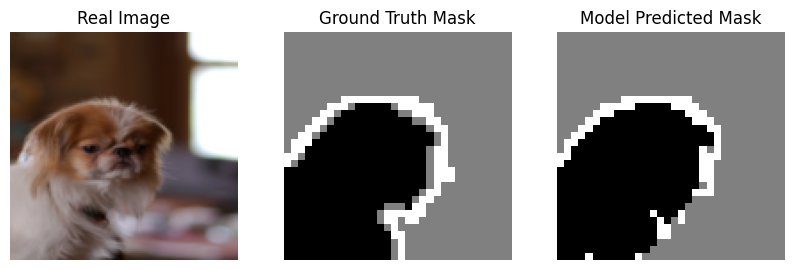

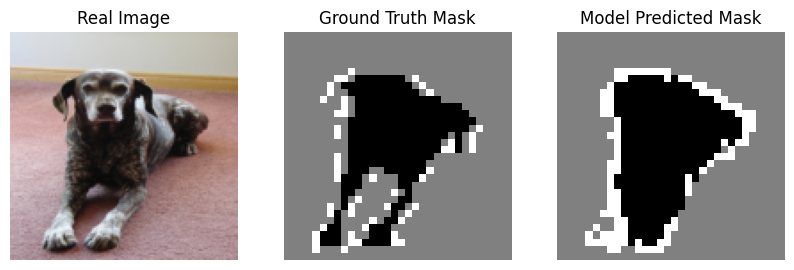

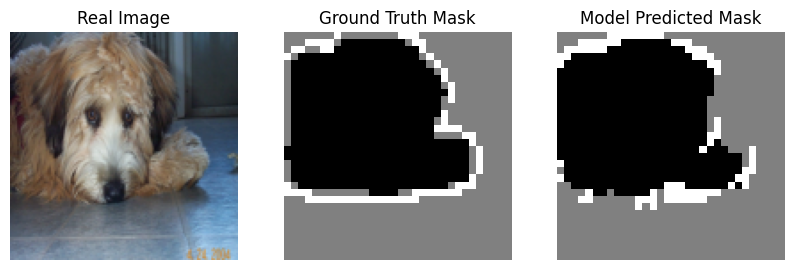

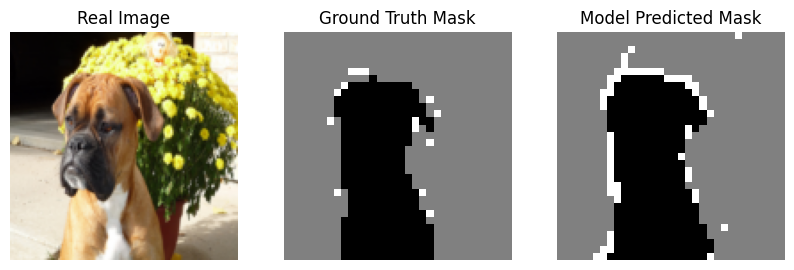

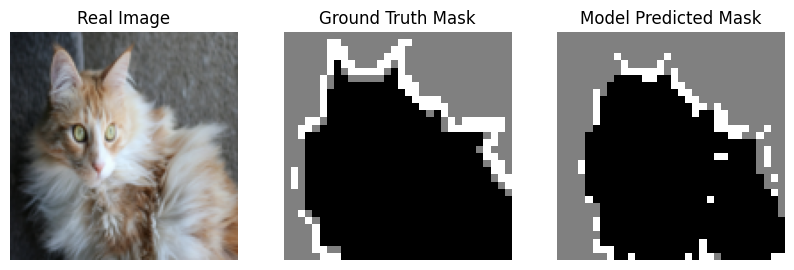

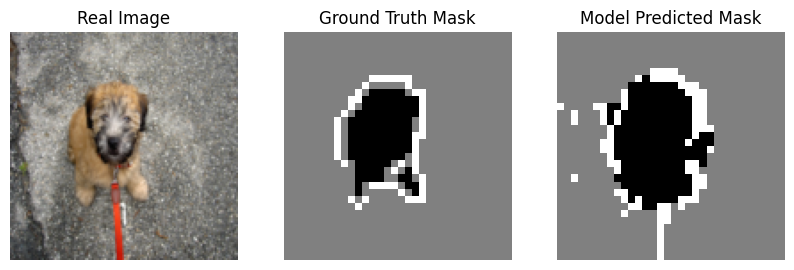

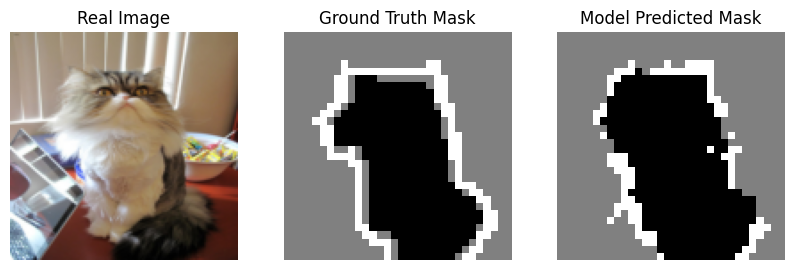

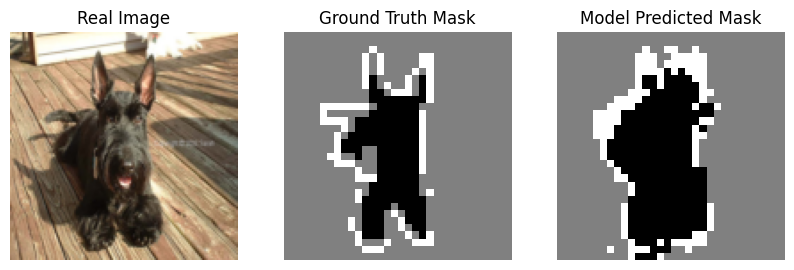

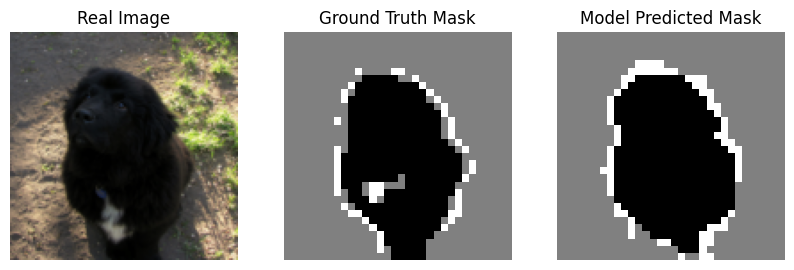

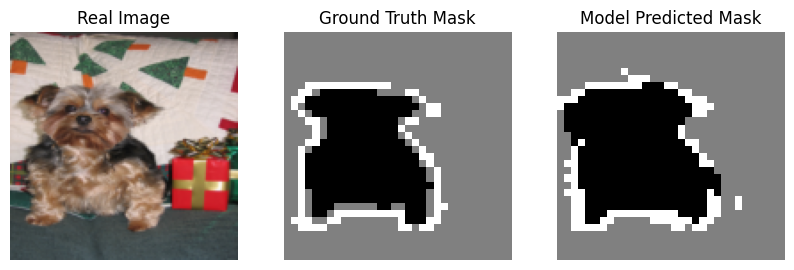

In [ ]:
def sample_image(idx):
  reverse_transforms = transforms.Compose([
    #transforms.Lambda(lambda t: (t + 1.) / 2),
    transforms.Lambda(lambda t: t * 255.),
    transforms.Lambda(lambda t: t.cpu().detach().numpy().astype(np.uint8)),
    transforms.Lambda(lambda t: t.squeeze()),
    #transforms.ToPILImage(),
  ])
  data_iter = iter(train_loader)
  images, masks = next(data_iter)
  image = images[idx]
  mask = masks[idx]

  pred_mask = model(image.to(device).unsqueeze(0))
  pred_mask = reverse_transforms(pred_mask)

  mask = mask.squeeze(0)

  fig, ax = plt.subplots(1, 3, figsize=(10, 5))
  #image = reverse_transforms(image)
  image = image.permute(1, 2, 0).cpu().numpy()

  ax[0].imshow(image)
  ax[0].set_title('Real Image')
  ax[0].axis('off')

  ax[1].imshow(mask.argmax(dim=0).cpu().numpy(), cmap = 'gray')
  ax[1].set_title('Ground Truth Mask')
  ax[1].axis('off')

  ax[2].imshow(torch.Tensor(pred_mask).argmax(dim=0).cpu().numpy(), cmap = 'gray')
  ax[2].set_title('Model Predicted Mask')
  ax[2].axis('off')

  plt.show()


def sample_images(num):
  for i in range(num):
    sample_idx = int((torch.rand(1) * 32).item())
    sample_image(sample_idx)

sample_images(10)

In [ ]:
model = SegFormer(
    in_channels = 3,
    widths = [64, 128, 256, 512],
    depths = [3, 4, 6, 3],
    all_num_heads = [1, 2, 4, 8],
    patch_sizes = [7, 3, 3, 3],
    overlap_sizes = [4, 2, 2, 2],
    reduction_ratios = [8, 4, 2, 1],
    mlp_expansions = [4, 4, 4, 4],
    decoder_channels = 256,
    scale_factors = [8, 4, 2, 1],
    num_classes = 3)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

SegFormer(
  (encoder): SegFormerEncoder(
    (stages): ModuleList(
      (0): SegFormerEncoderStage(
        (overlap_patch_merge): OverlapPatchMerging(
          (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3), bias=False)
          (layer_norm): LayerNorm2d((64,), eps=1e-05, elementwise_affine=True)
        )
        (blocks): Sequential(
          (0): SegFormerEncoderBlock(
            (layer_1): ResidualAdd(
              (fn): Sequential(
                (0): LayerNorm2d((64,), eps=1e-05, elementwise_affine=True)
                (1): EfficientMultiHeadAttention(
                  (reducer): Sequential(
                    (0): Conv2d(64, 64, kernel_size=(8, 8), stride=(8, 8))
                    (1): LayerNorm2d((64,), eps=1e-05, elementwise_affine=True)
                  )
                  (attention): MultiheadAttention(
                    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
                  )
     

In [ ]:
def dice_loss(pred, target, smooth=1.):
    num_classes = pred.shape[1]
    dice = torch.zeros(num_classes).to(pred.device)
    for c in range(num_classes):
        intersection = (pred[:, c, :, :] * target[:, c, :, :]).sum()
        dice[c] = (2. * intersection + smooth) / (pred[:, c, :, :].sum() + target[:, c, :, :].sum() + smooth)
    return 1 - dice.mean()

def compound_dice_loss(pred, target, alpha=0.2):
    return alpha * dice_loss(pred, target) + (1 - alpha) * nn.MSELoss()(pred, target)

def tversky_loss(pred, target, alpha=1.1, beta=0.7, smooth=1e-7):
    num_classes = pred.shape[1]
    tversky = torch.zeros(num_classes).to(pred.device)
    for c in range(num_classes):
        true_positives = (pred[:, c, :, :] * target[:, c, :, :]).sum()
        false_positives = (pred[:, c, :, :] * (1 - target[:, c, :, :])).sum()
        false_negatives = ((1 - pred[:, c, :, :]) * target[:, c, :, :]).sum()
        tversky[c] = (true_positives + smooth) / (true_positives + alpha * false_negatives + beta * false_positives + smooth)
    return 1 - tversky.mean()


def compound_tversky_loss(pred, target, alpha = 0.6, beta = 0.4, gamma = 0.8):
  return alpha * tversky_loss(pred, target) + beta * nn.CrossEntropyLoss()(pred, target) + gamma * dice_loss(pred, target)

In [ ]:
class CompoundLoss(nn.Module):
    def __init__(self, dice_weight=0.5):
        super(CompoundLoss, self).__init__()
        self.dice_weight = dice_weight
        self.cross_entropy_loss = nn.CrossEntropyLoss()

    def dice_loss(self, input, target):
        smooth = 1.0
        dice = 0
        num_classes = input.shape[1]

        for c in range(num_classes):
            iflat = input[:, c].view(-1)
            tflat = target[:, c].view(-1)
            intersection = (iflat * tflat).sum()
            dice += (2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth)

        return 1 - (dice / num_classes)

    def forward(self, input, target):
        dice = self.dice_loss(input, target)
        ce = self.cross_entropy_loss(input, target.argmax(dim=1))
        return self.dice_weight * dice + (1 - self.dice_weight) * ce

Epochs:   0%|          | 0/75 [00:00<?, ?it/s]

Steps:   0%|          | 0/58 [00:00<?, ?it/s]

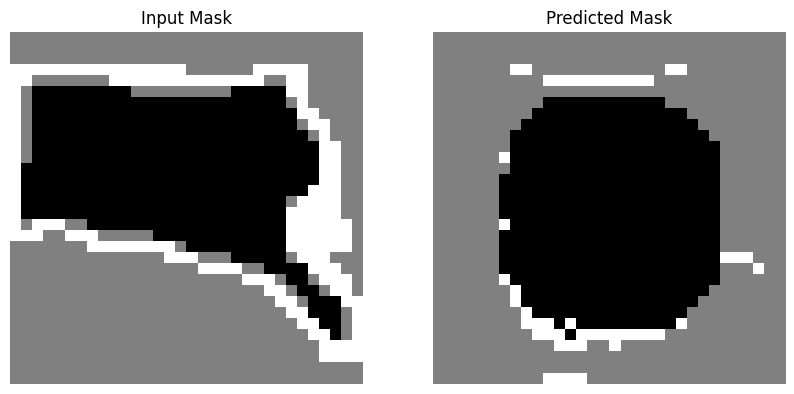

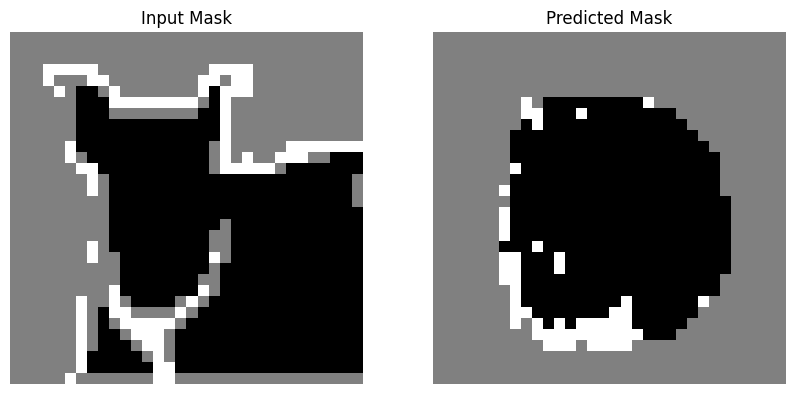

Epoch [1/75], Step [58/58], Loss: 1.1140073537826538


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

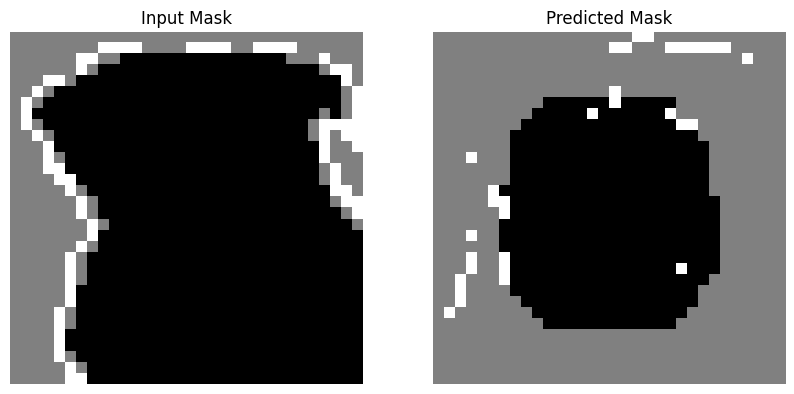

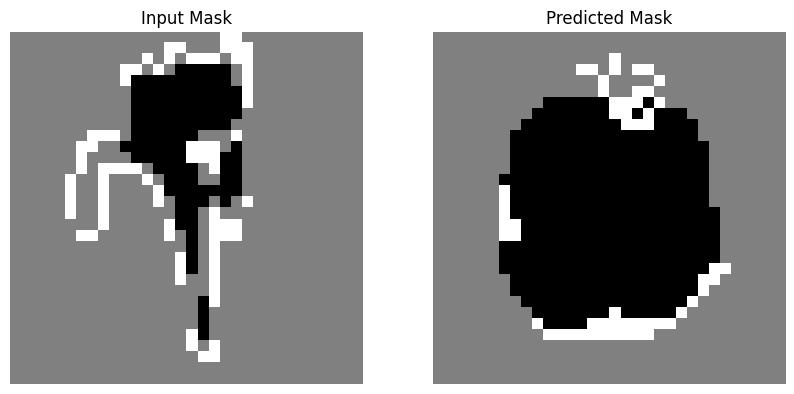

Epoch [2/75], Step [58/58], Loss: 1.0746312141418457


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

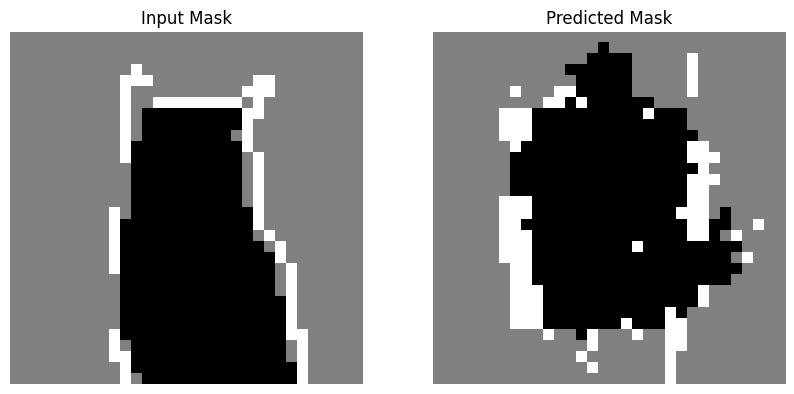

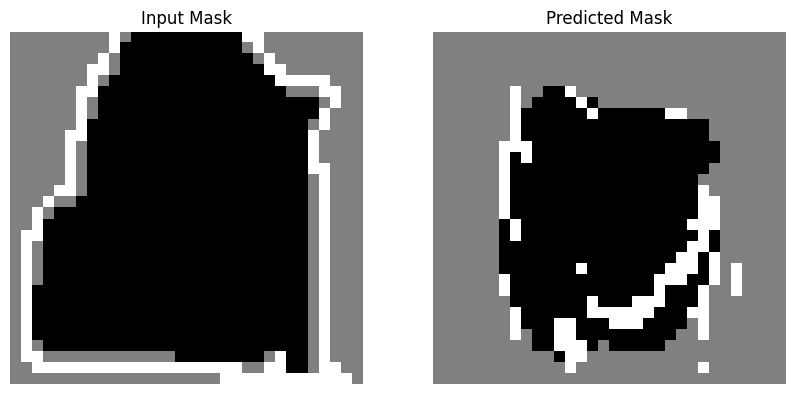

Epoch [3/75], Step [58/58], Loss: 1.023126482963562


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

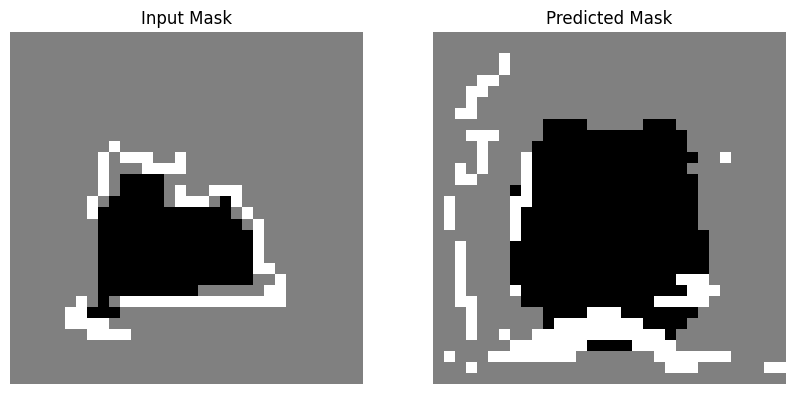

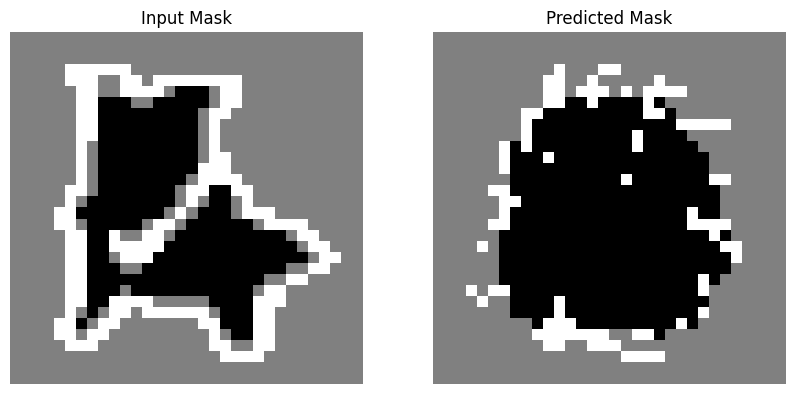

Epoch [4/75], Step [58/58], Loss: 1.0141525268554688


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

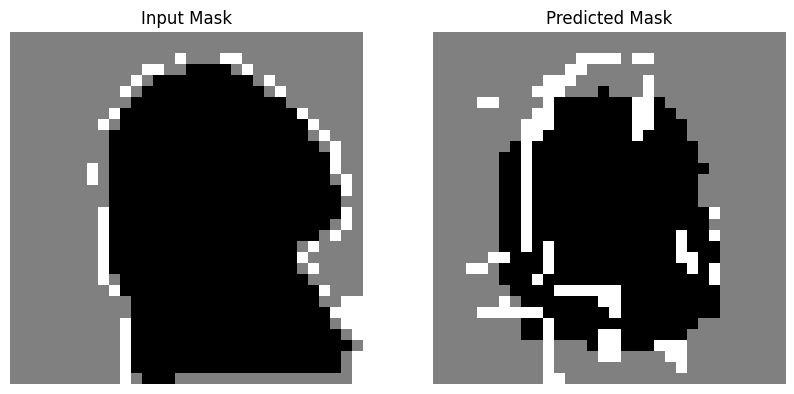

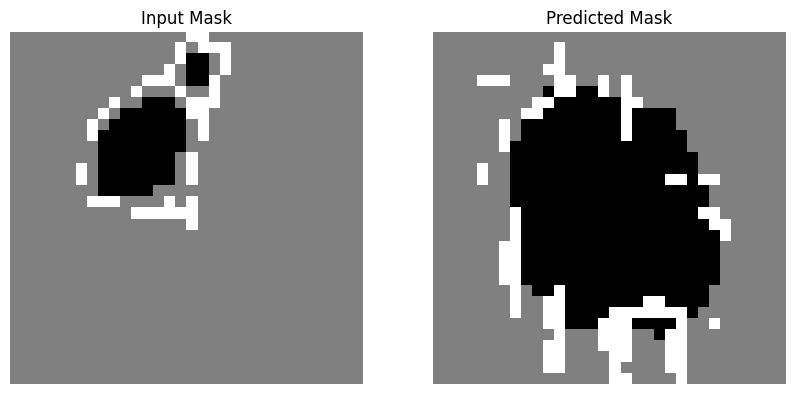

Epoch [5/75], Step [58/58], Loss: 0.9549764394760132


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

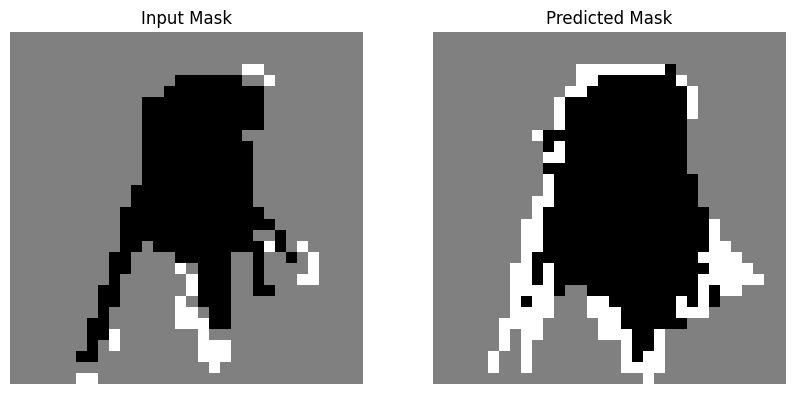

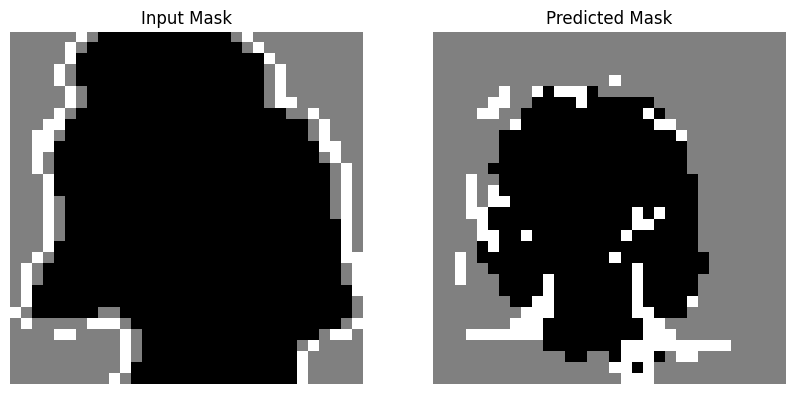

Epoch [6/75], Step [58/58], Loss: 0.9373561143875122


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

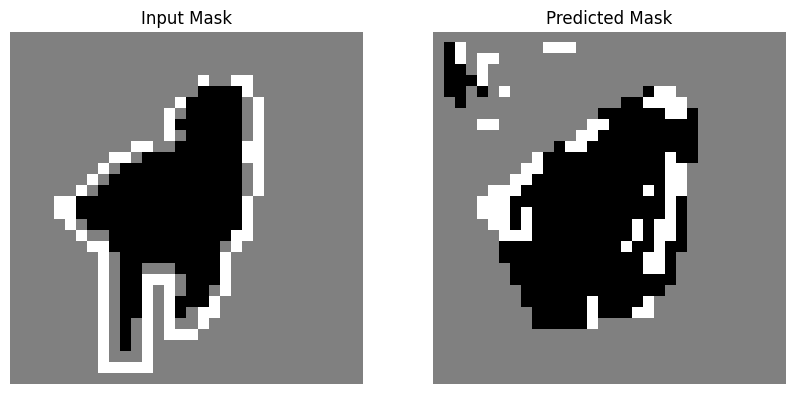

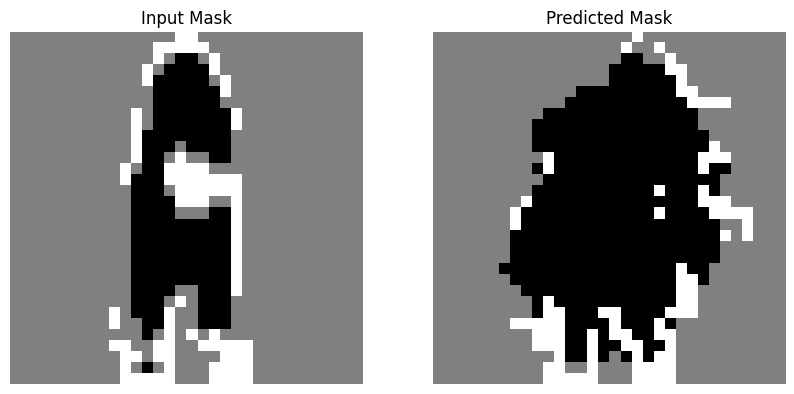

Epoch [7/75], Step [58/58], Loss: 0.858813464641571


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

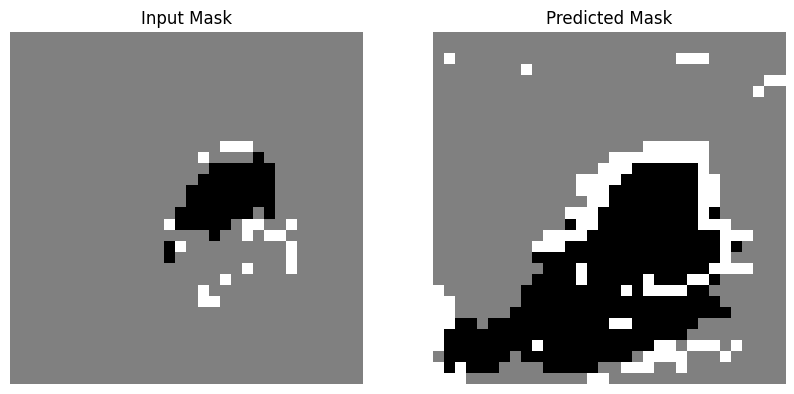

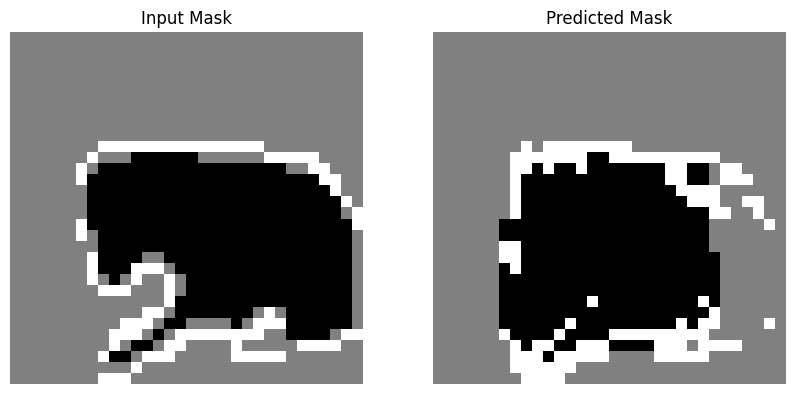

Epoch [8/75], Step [58/58], Loss: 0.8258088827133179


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

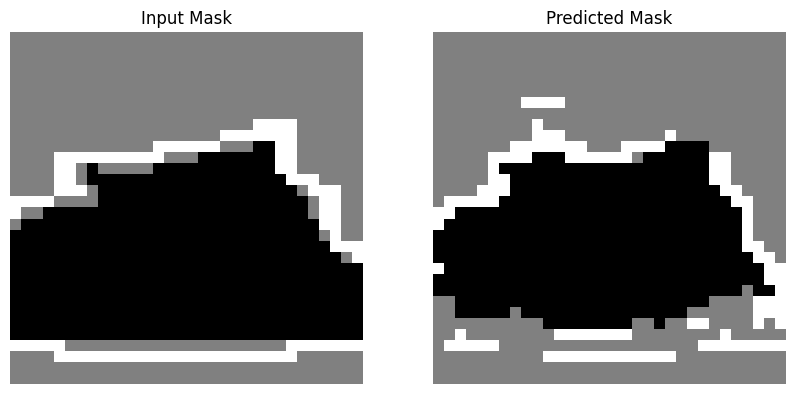

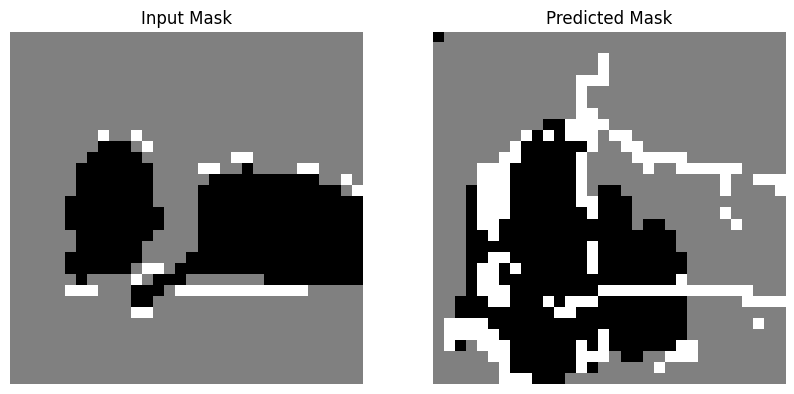

Epoch [9/75], Step [58/58], Loss: 0.8112634420394897


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

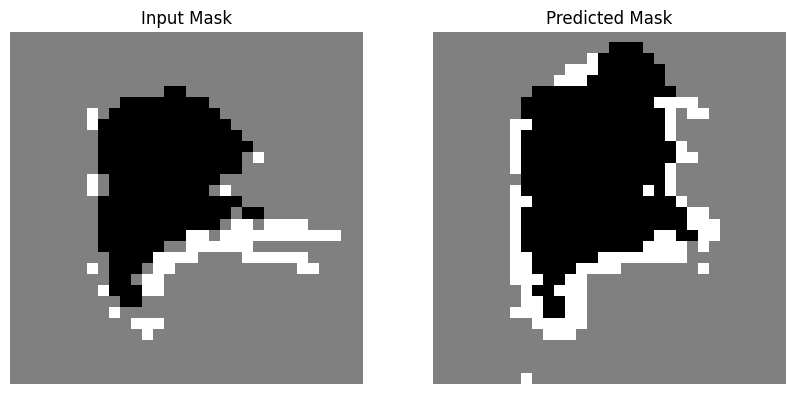

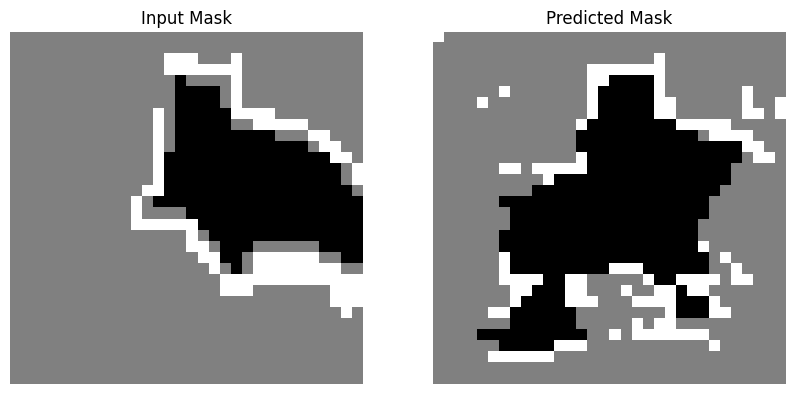

Epoch [10/75], Step [58/58], Loss: 0.7885156273841858


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

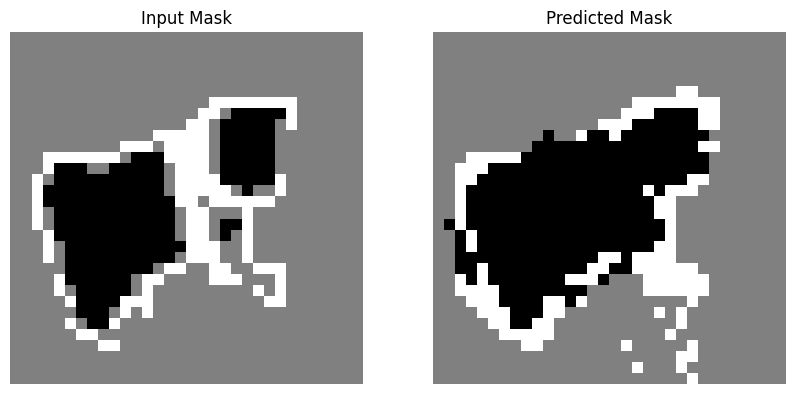

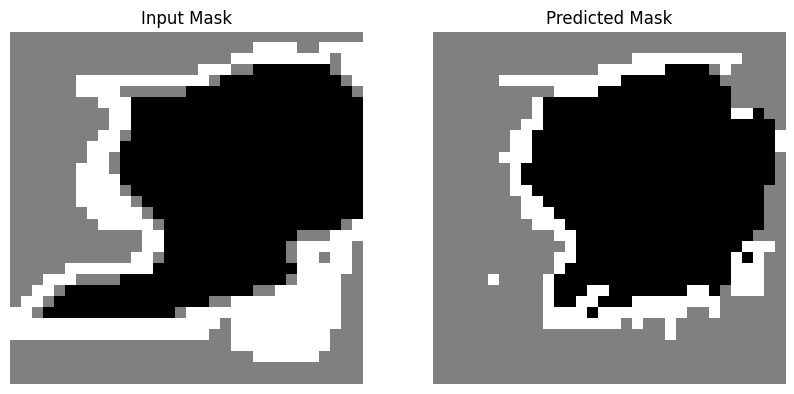

Epoch [11/75], Step [58/58], Loss: 0.7866355180740356


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

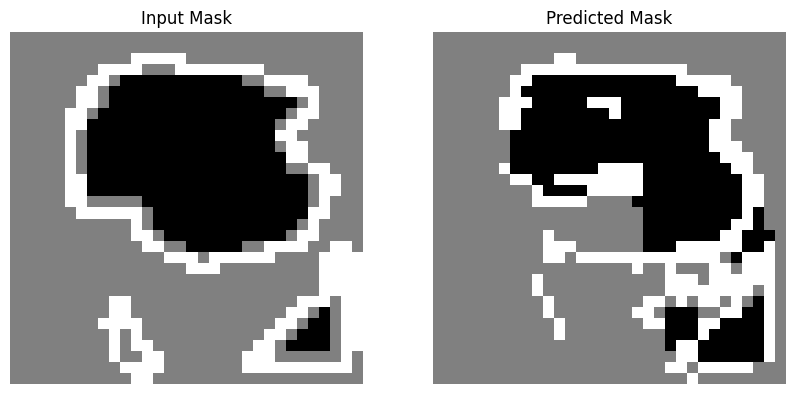

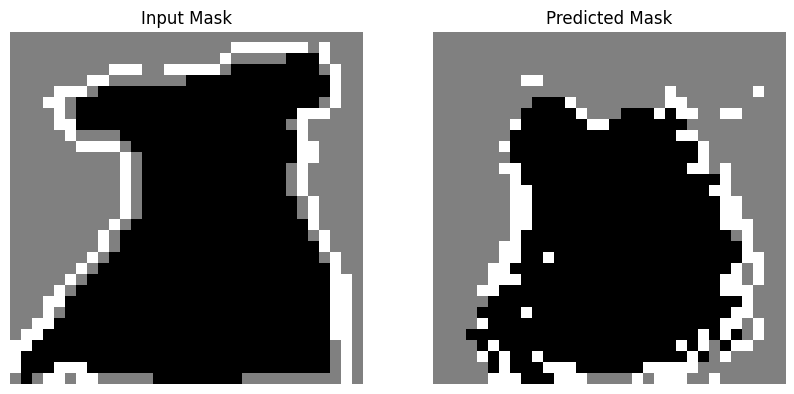

Epoch [12/75], Step [58/58], Loss: 0.8335051536560059


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

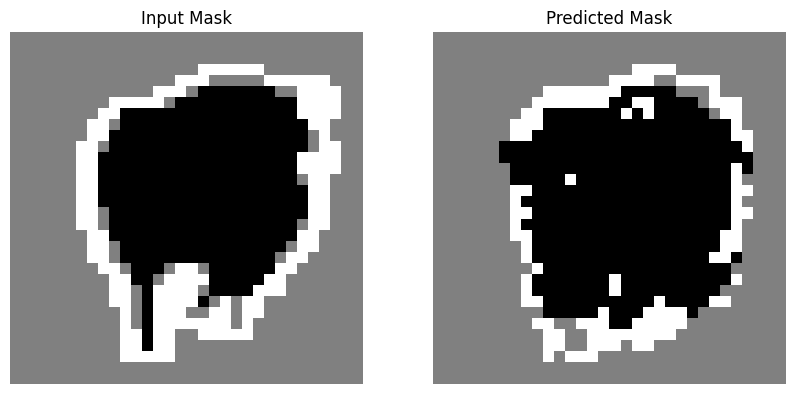

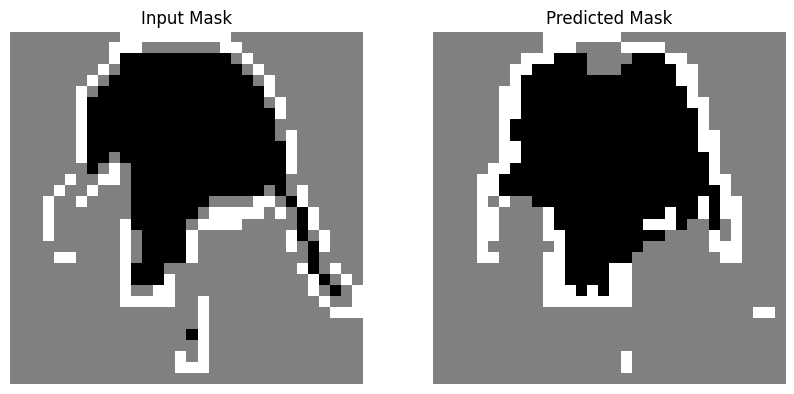

Epoch [13/75], Step [58/58], Loss: 0.7275427579879761


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

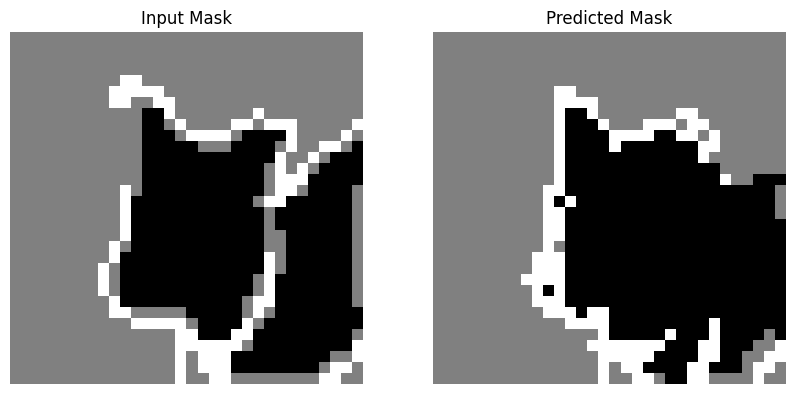

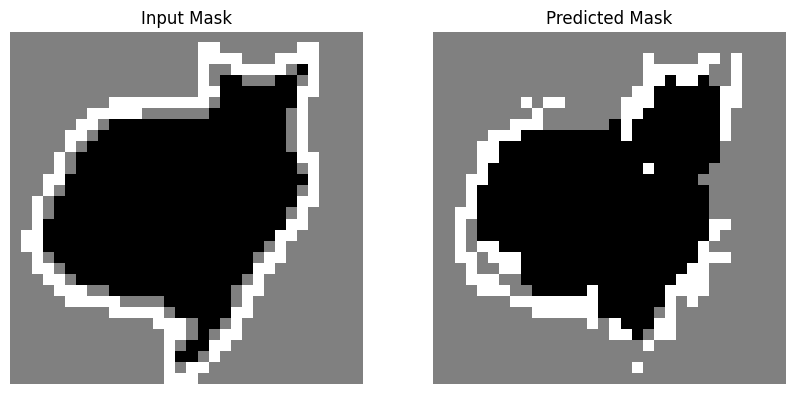

Epoch [14/75], Step [58/58], Loss: 0.7286992073059082


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

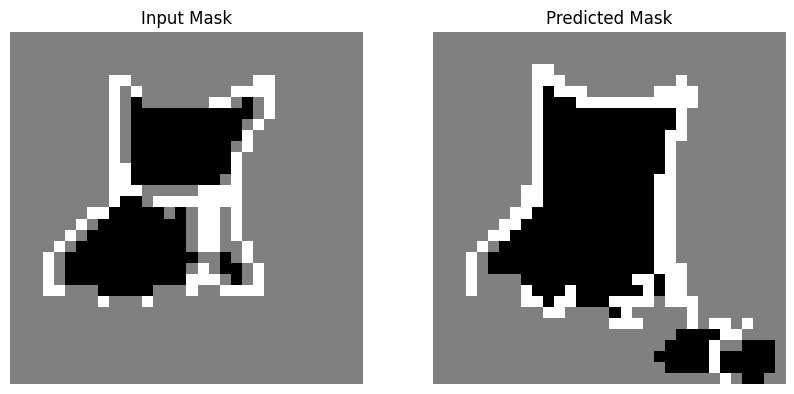

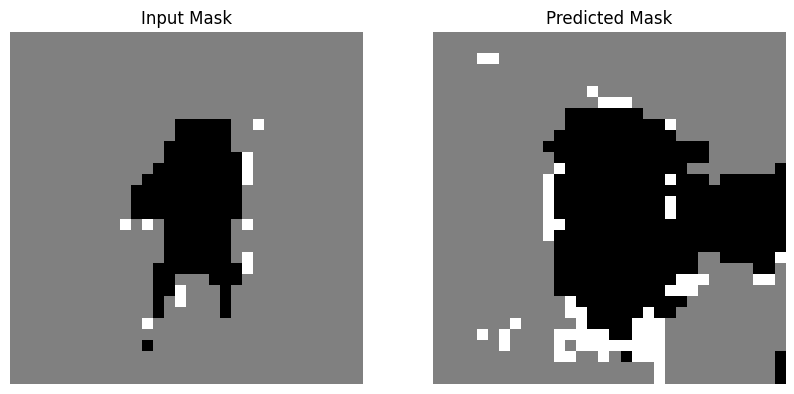

Epoch [15/75], Step [58/58], Loss: 0.6819141507148743


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

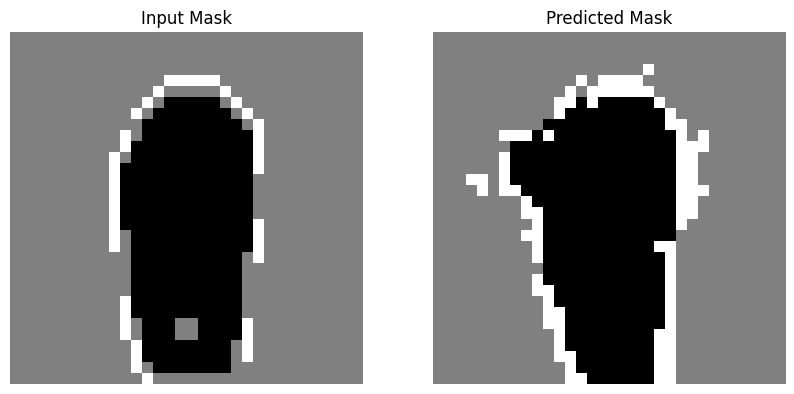

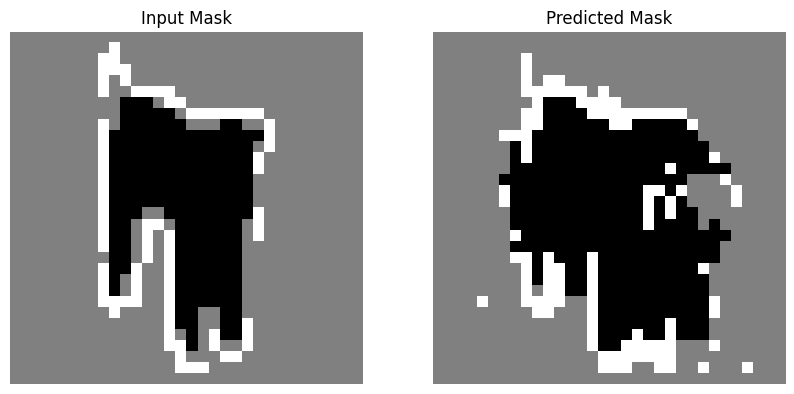

Epoch [16/75], Step [58/58], Loss: 0.7043187618255615


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

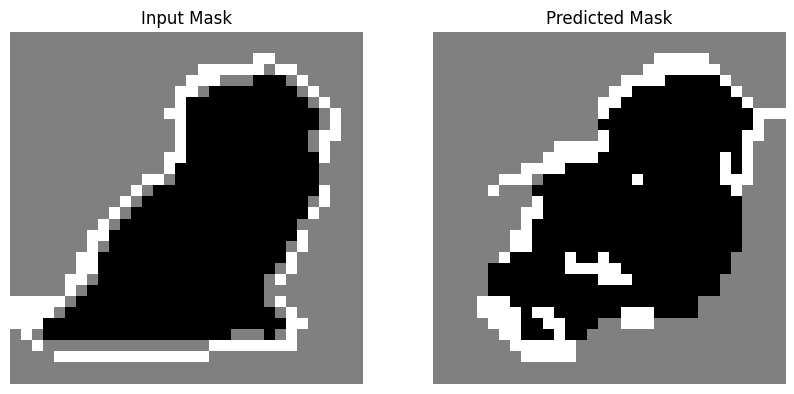

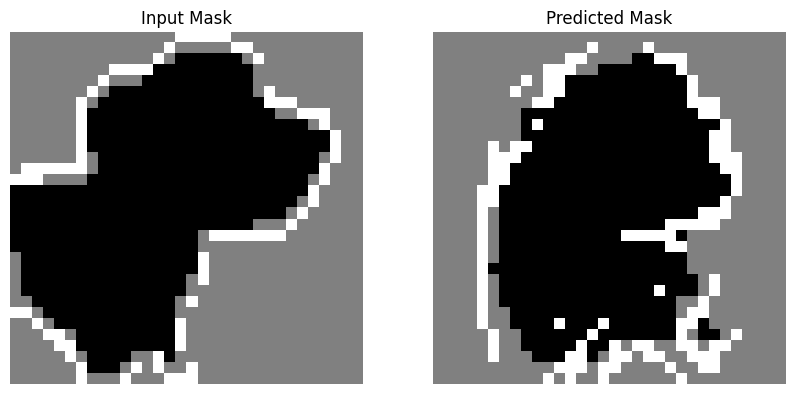

Epoch [17/75], Step [58/58], Loss: 0.6951707601547241


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

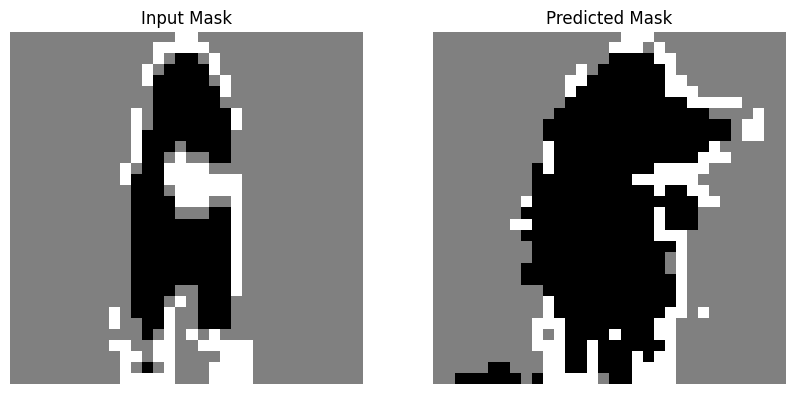

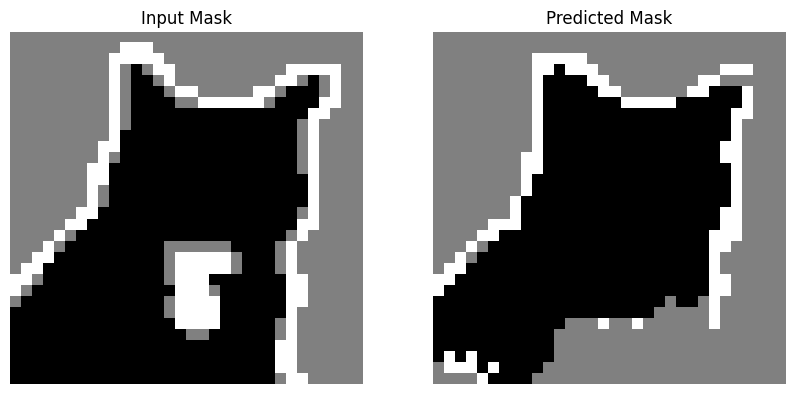

Epoch [18/75], Step [58/58], Loss: 0.6895450353622437


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

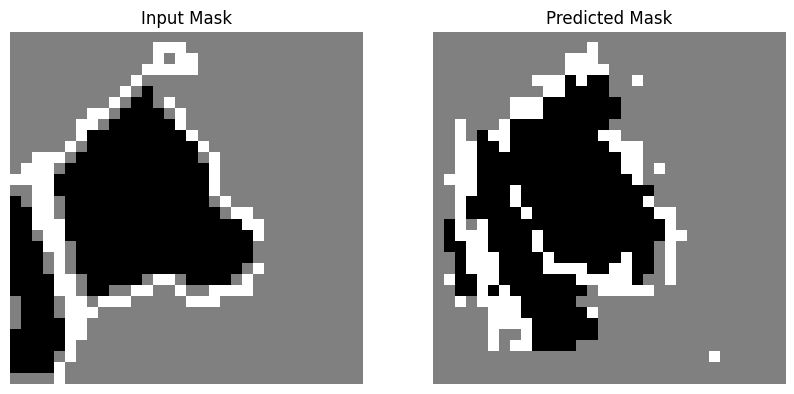

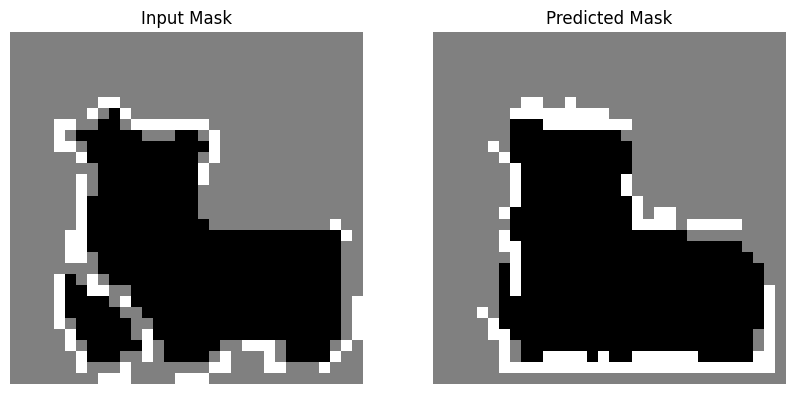

Epoch [19/75], Step [58/58], Loss: 0.6682785749435425


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

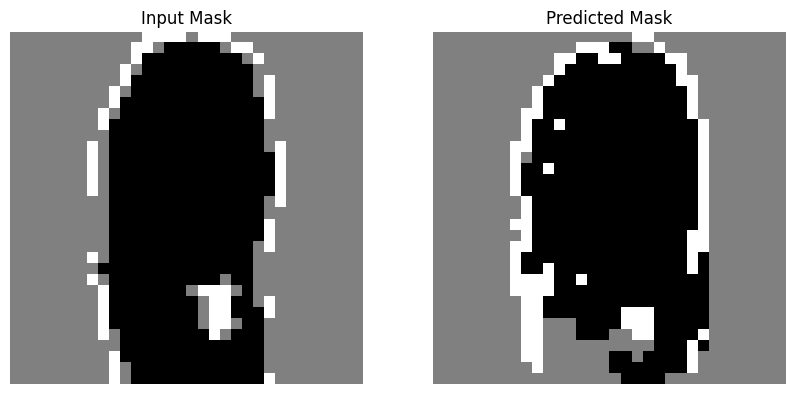

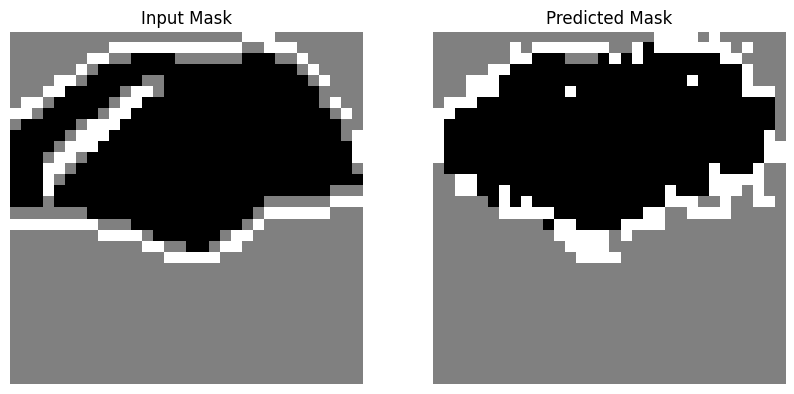

Epoch [20/75], Step [58/58], Loss: 0.6959311366081238


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

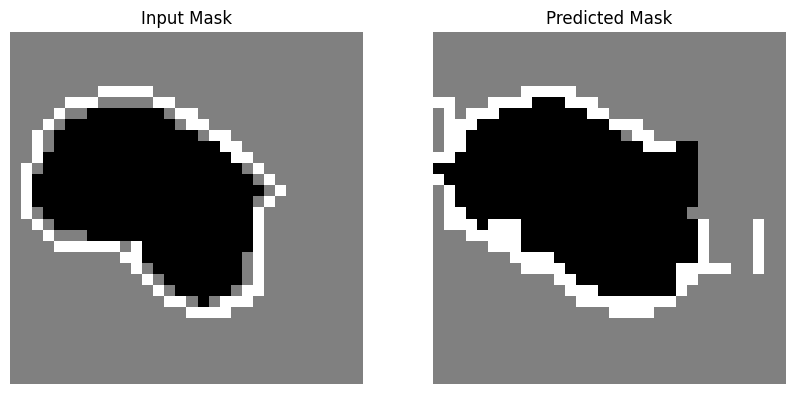

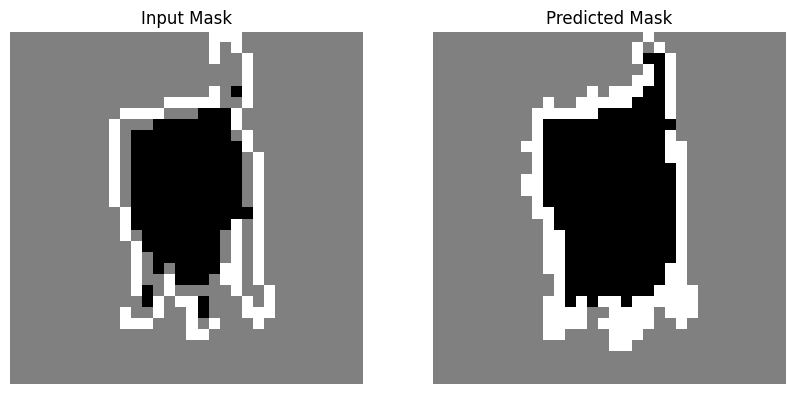

Epoch [21/75], Step [58/58], Loss: 0.620132327079773


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

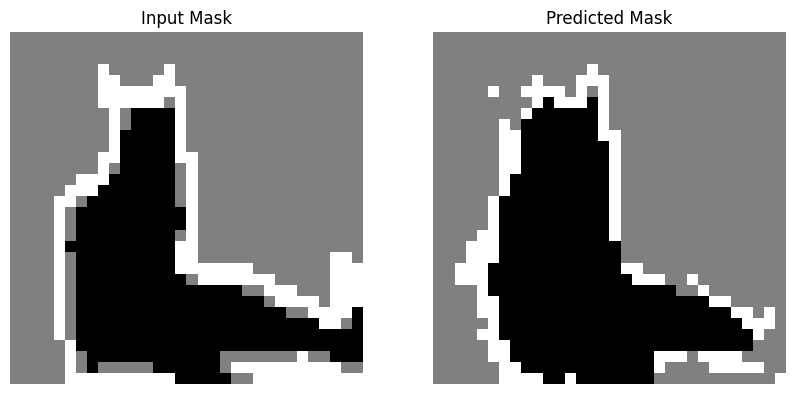

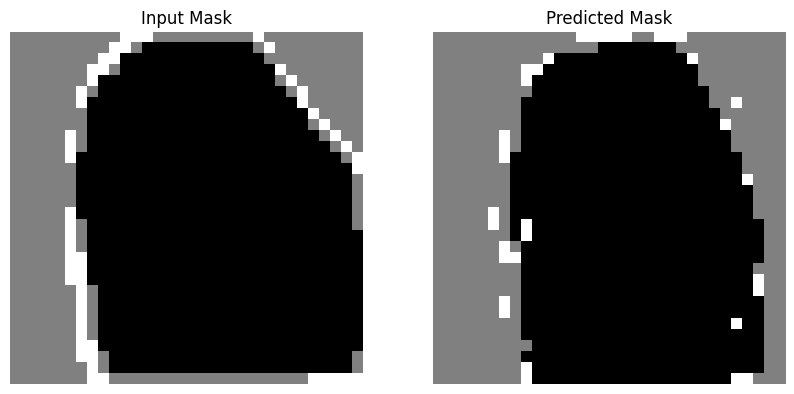

Epoch [22/75], Step [58/58], Loss: 0.6419102549552917


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

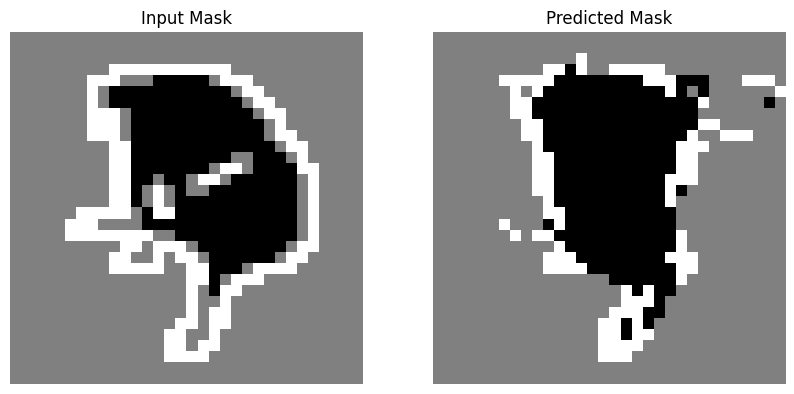

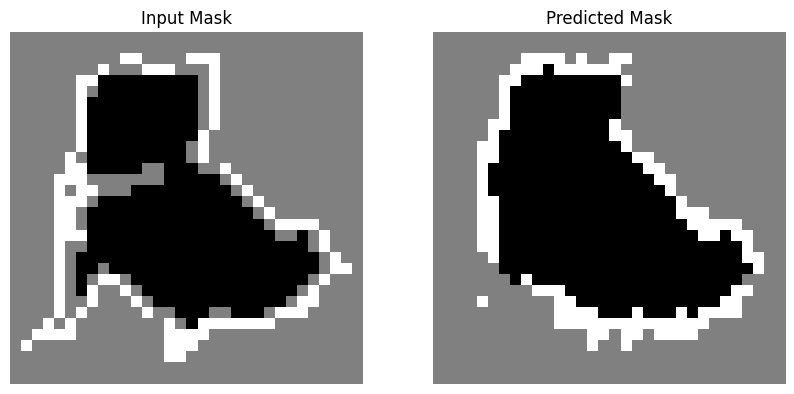

Epoch [23/75], Step [58/58], Loss: 0.6587002277374268


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

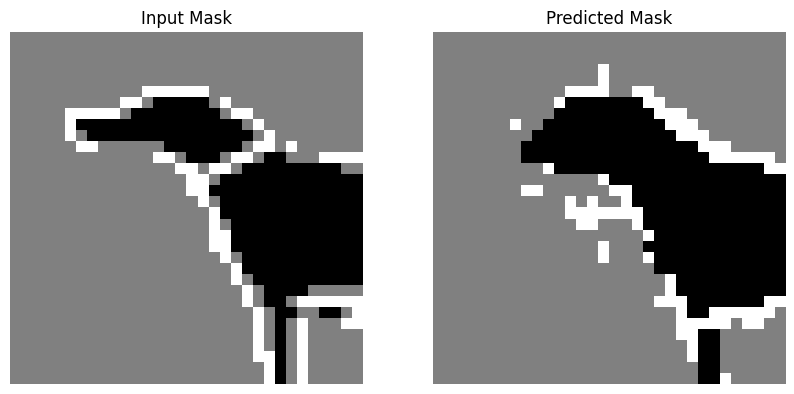

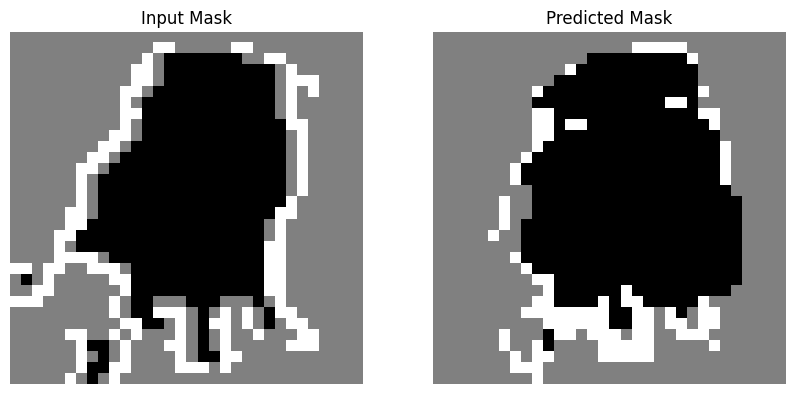

Epoch [24/75], Step [58/58], Loss: 0.6480031609535217


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

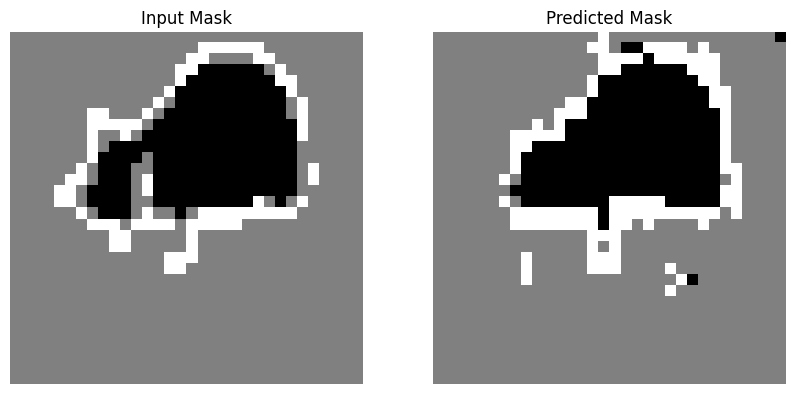

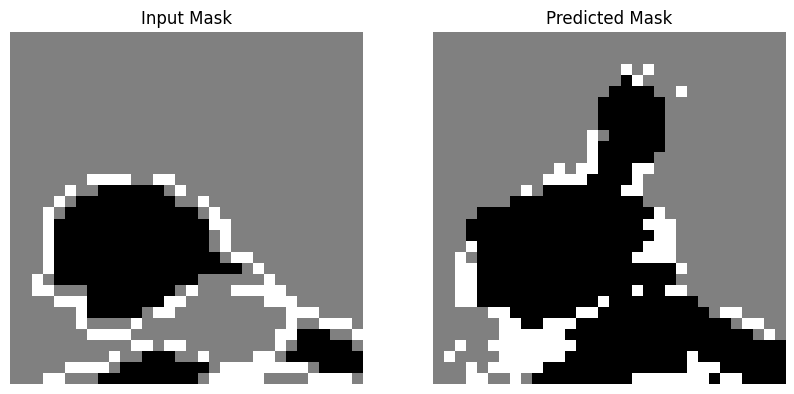

Epoch [25/75], Step [58/58], Loss: 0.6166982054710388


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

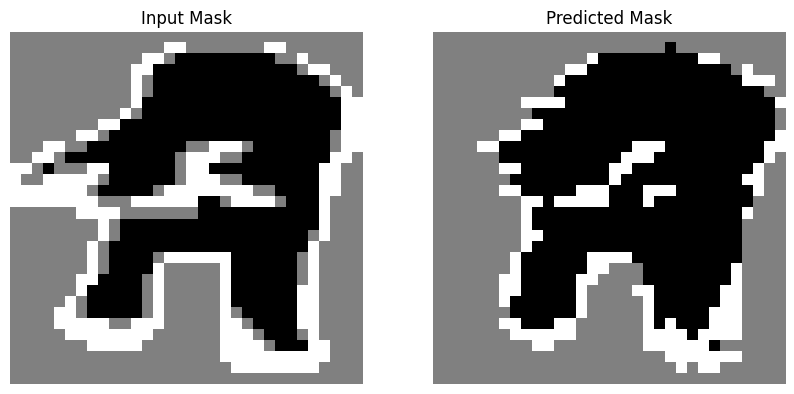

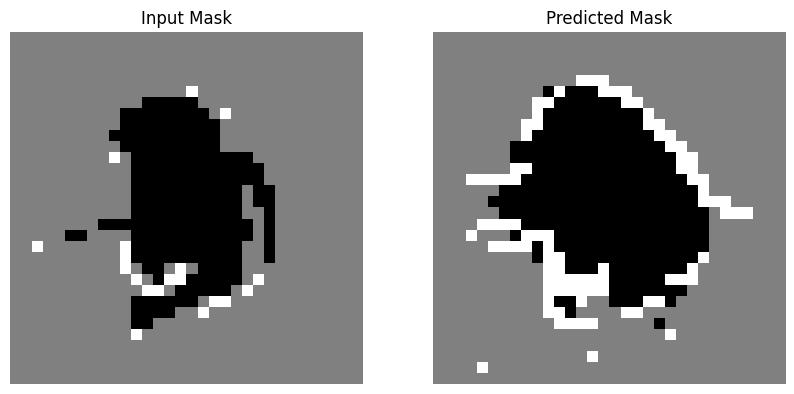

Epoch [26/75], Step [58/58], Loss: 0.6026538610458374


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

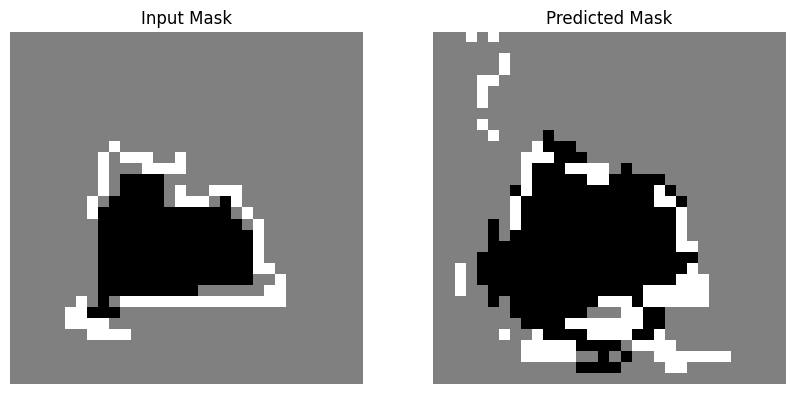

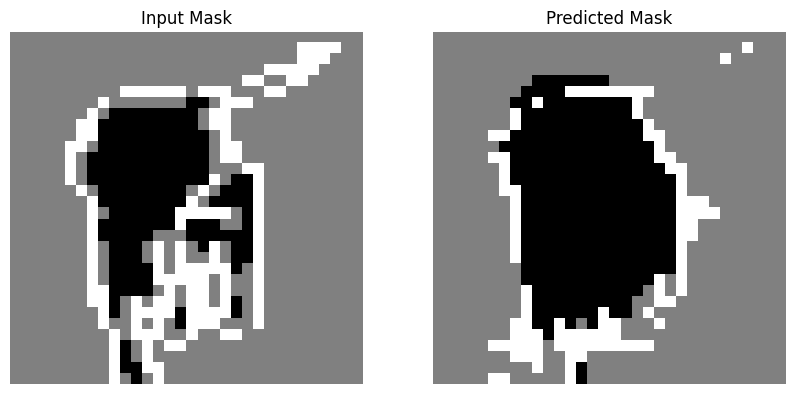

Epoch [27/75], Step [58/58], Loss: 0.6132405996322632


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

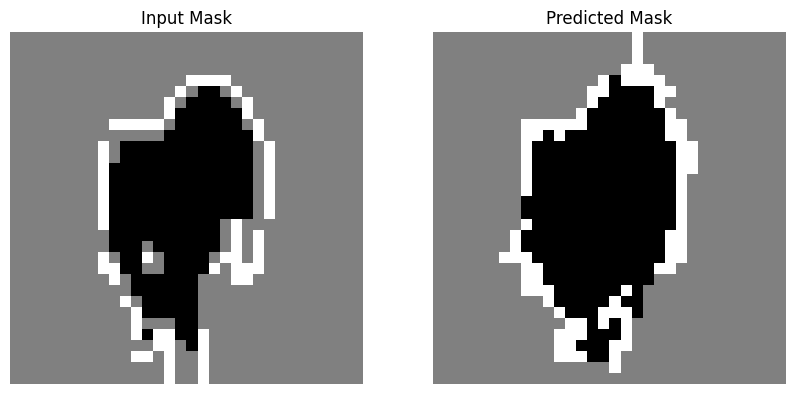

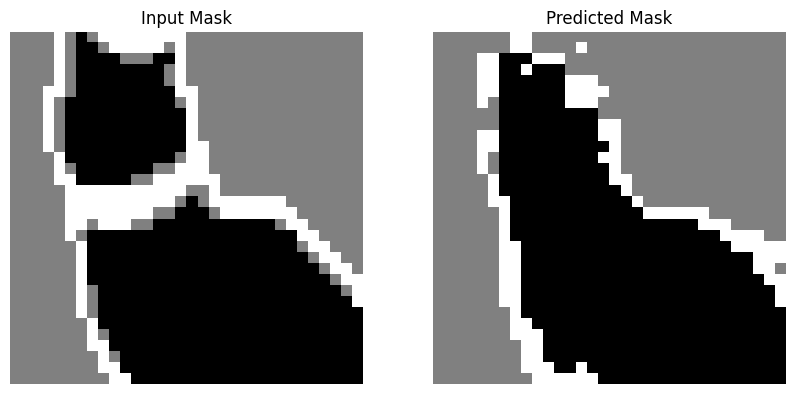

Epoch [28/75], Step [58/58], Loss: 0.6394790410995483


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

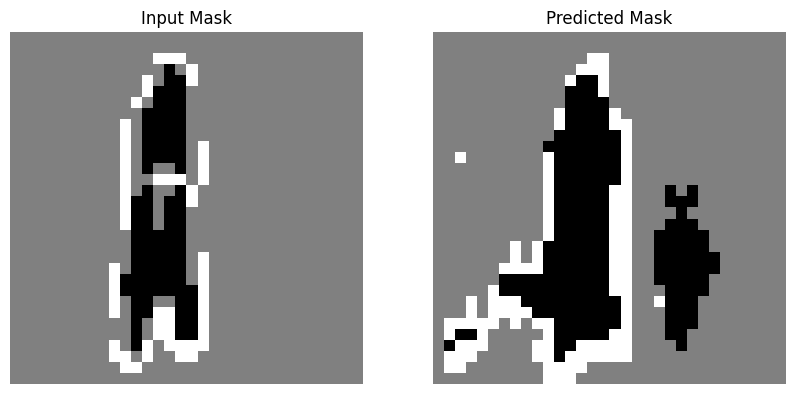

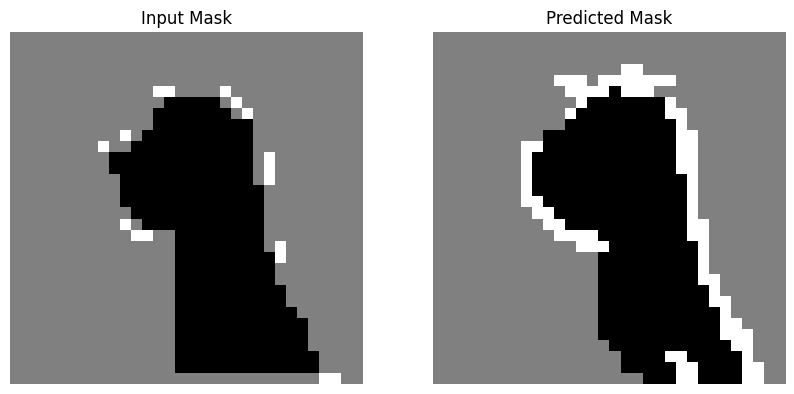

Epoch [29/75], Step [58/58], Loss: 0.5940248966217041


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

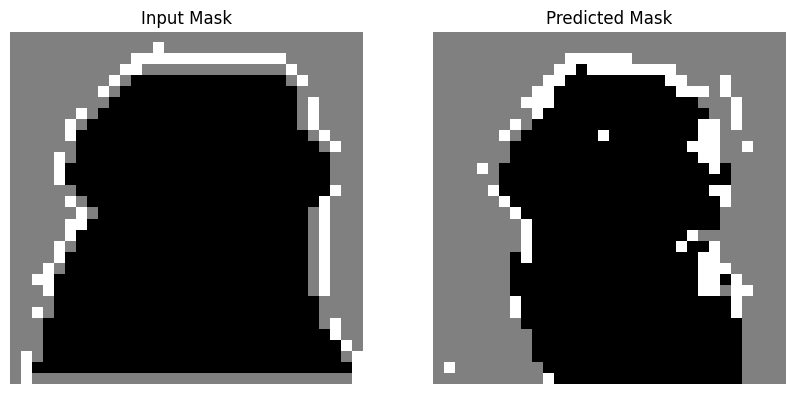

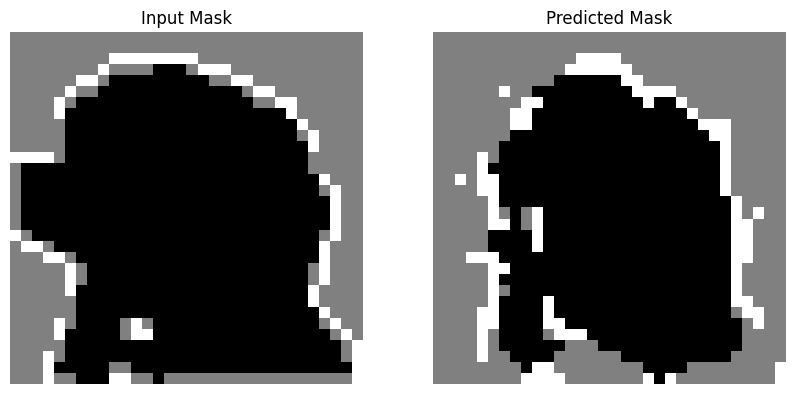

Epoch [30/75], Step [58/58], Loss: 0.6064451336860657


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

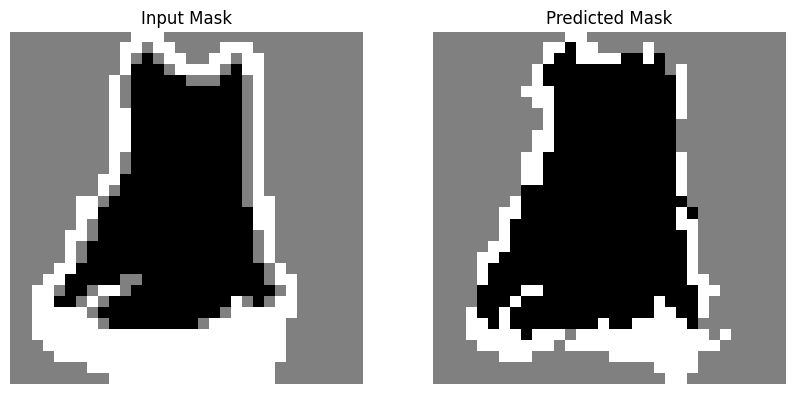

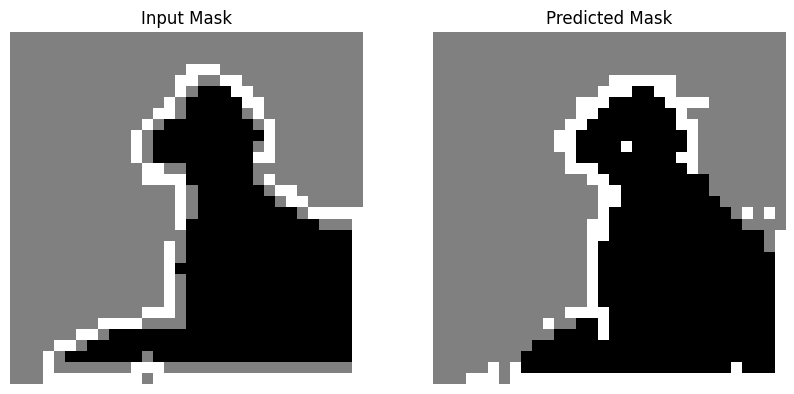

Epoch [31/75], Step [58/58], Loss: 0.5675079822540283


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

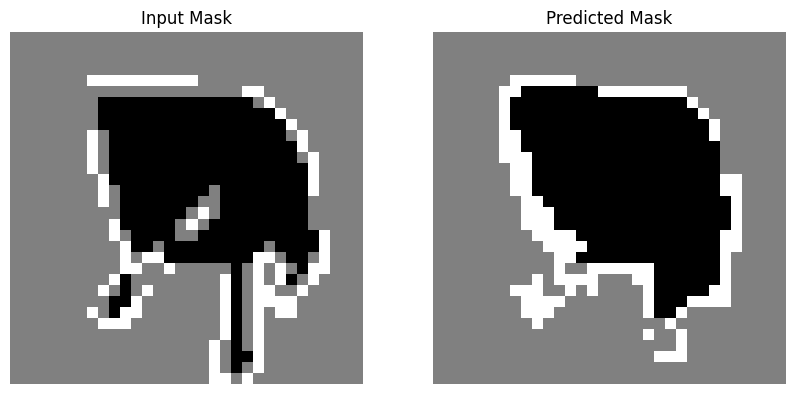

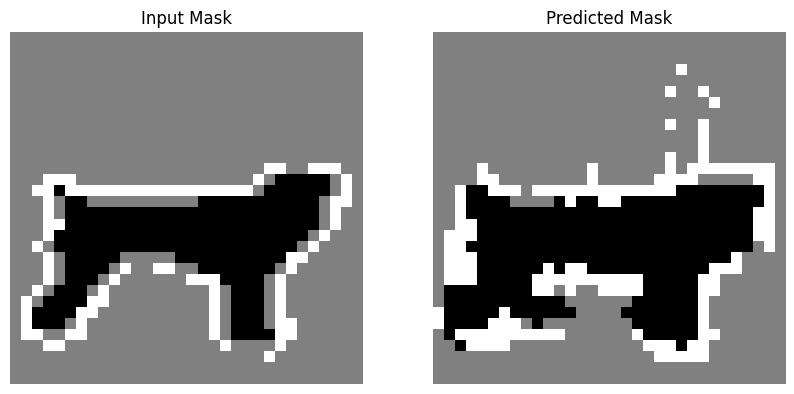

Epoch [32/75], Step [58/58], Loss: 0.613035261631012


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

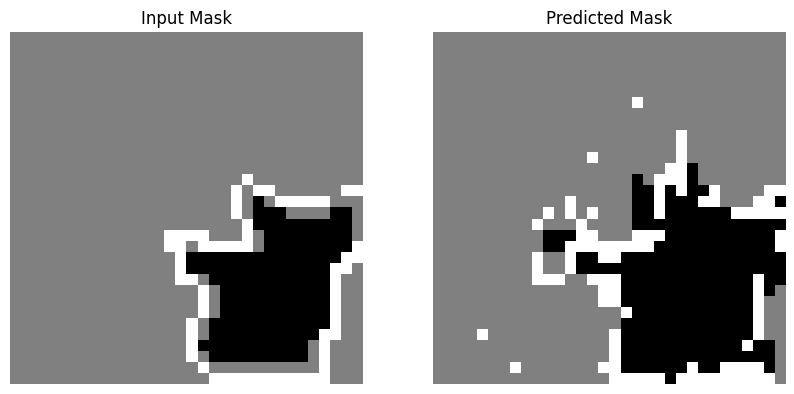

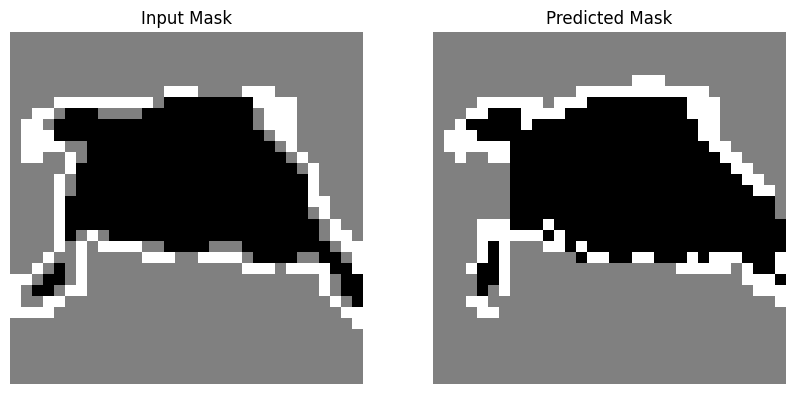

Epoch [33/75], Step [58/58], Loss: 0.6130415201187134


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

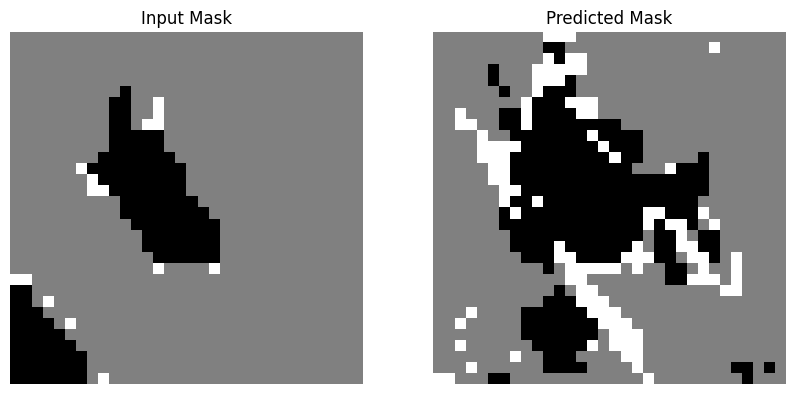

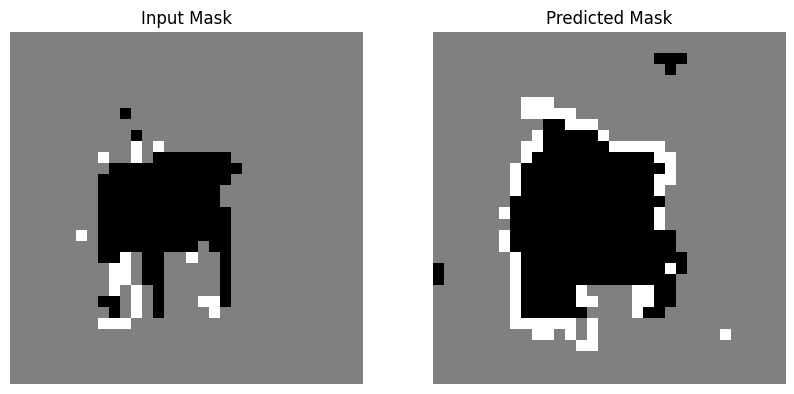

Epoch [34/75], Step [58/58], Loss: 0.635311484336853


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

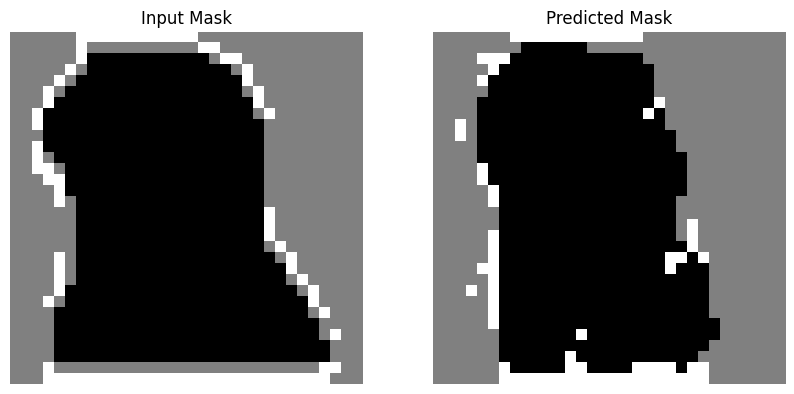

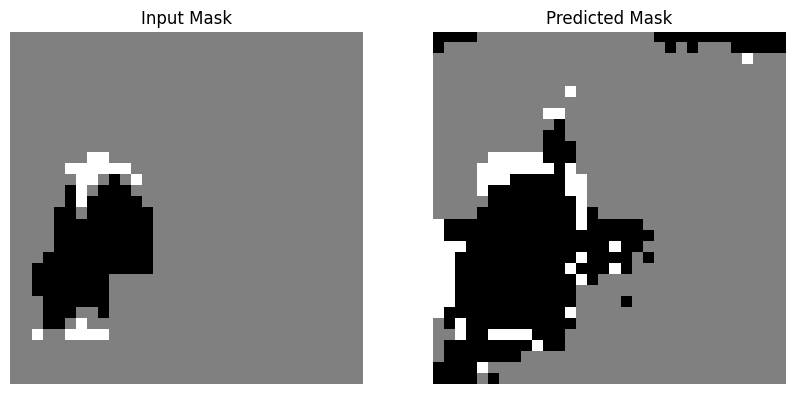

Epoch [35/75], Step [58/58], Loss: 0.6045466661453247


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

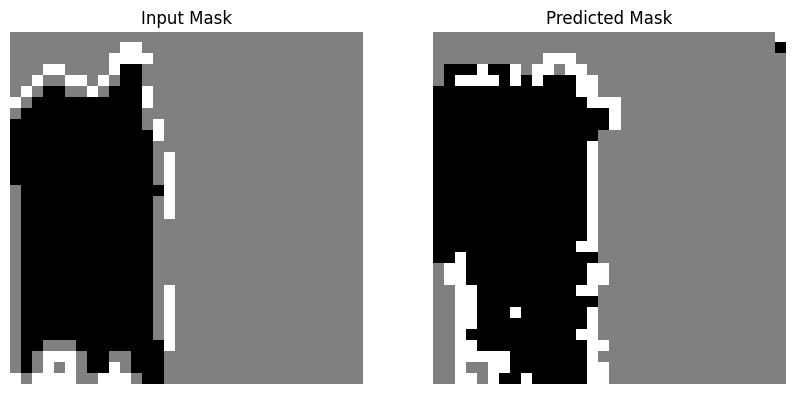

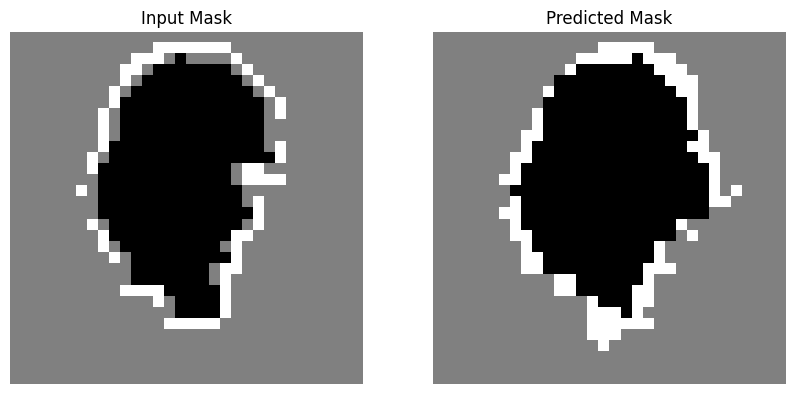

Epoch [36/75], Step [58/58], Loss: 0.5568503737449646


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

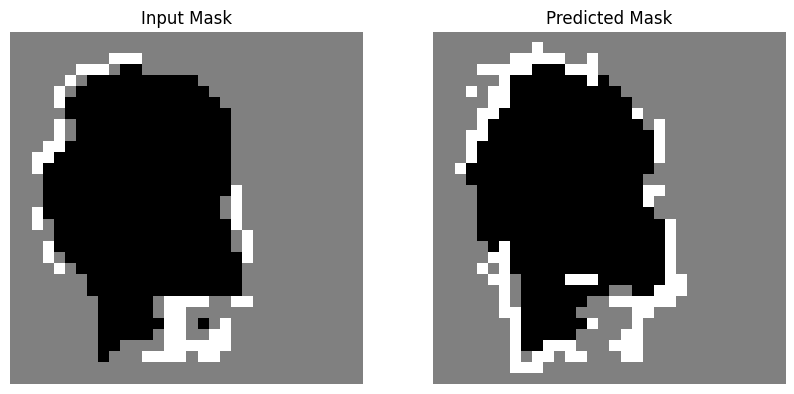

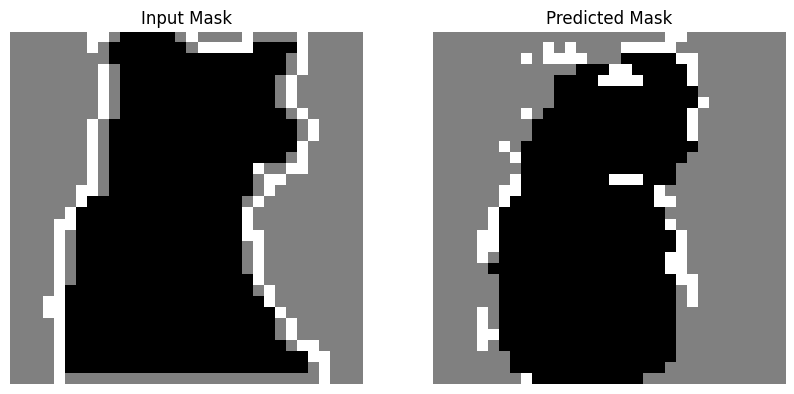

Epoch [37/75], Step [58/58], Loss: 0.5818305611610413


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

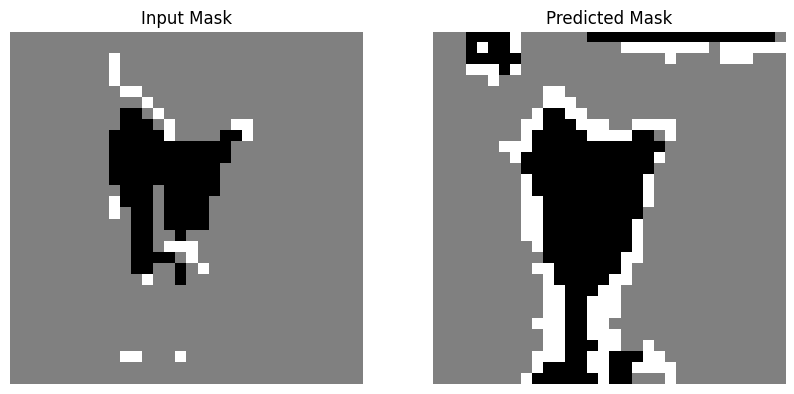

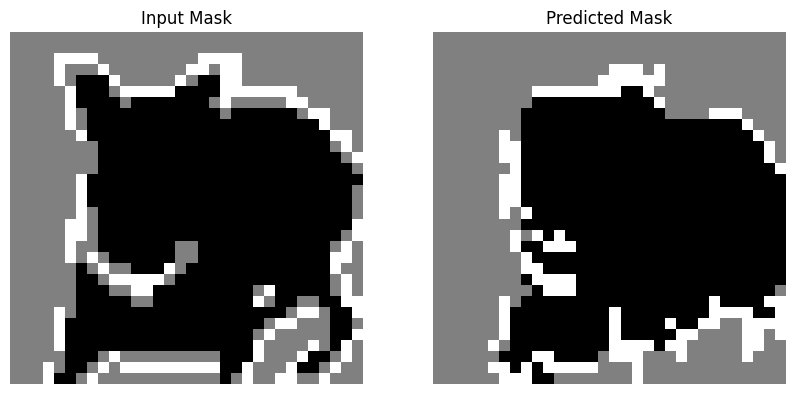

Epoch [38/75], Step [58/58], Loss: 0.5580822229385376


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

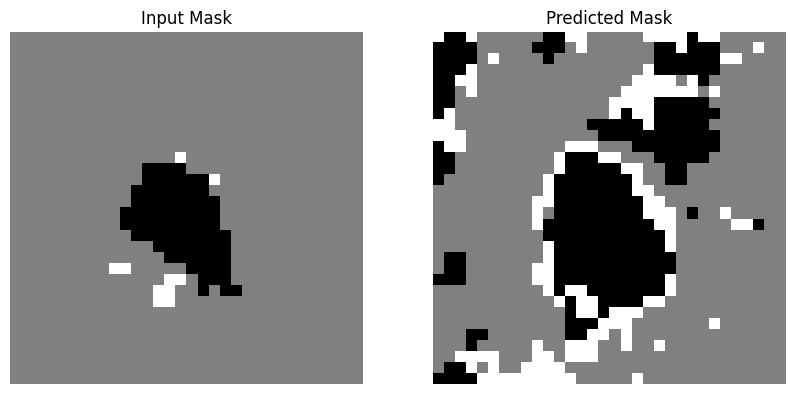

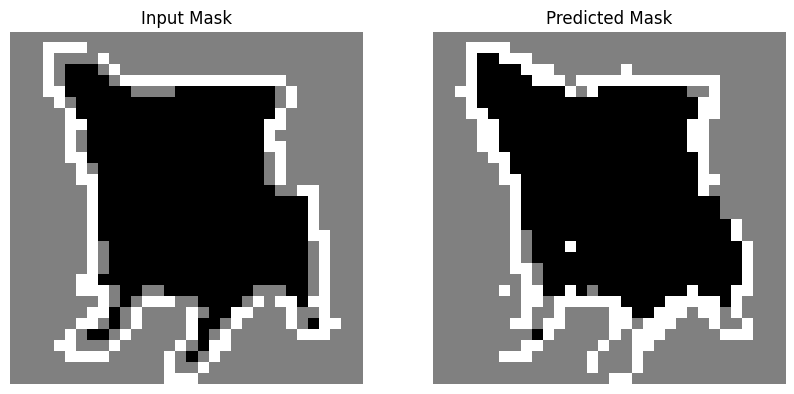

Epoch [39/75], Step [58/58], Loss: 0.5885483622550964


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

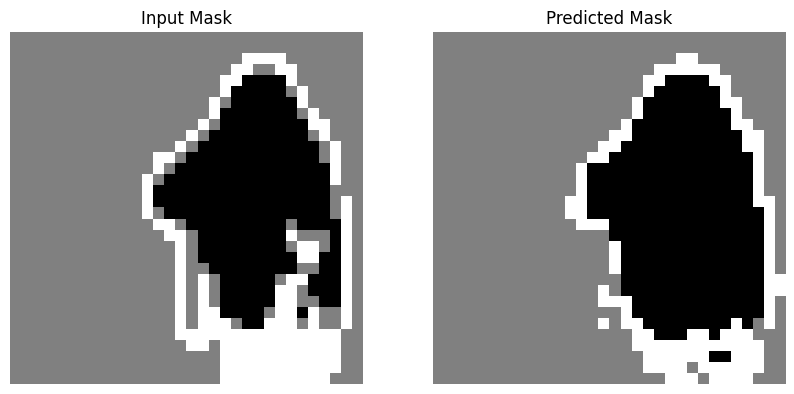

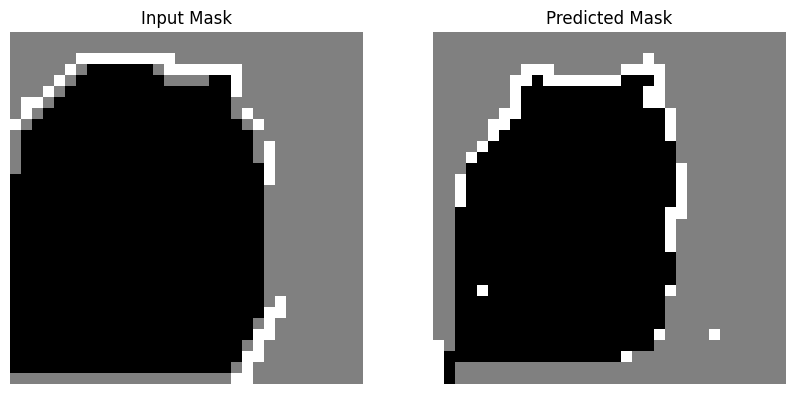

Epoch [40/75], Step [58/58], Loss: 0.5680584907531738


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

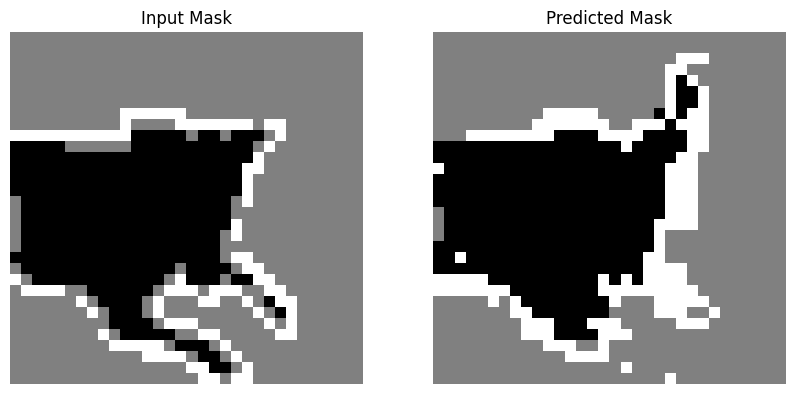

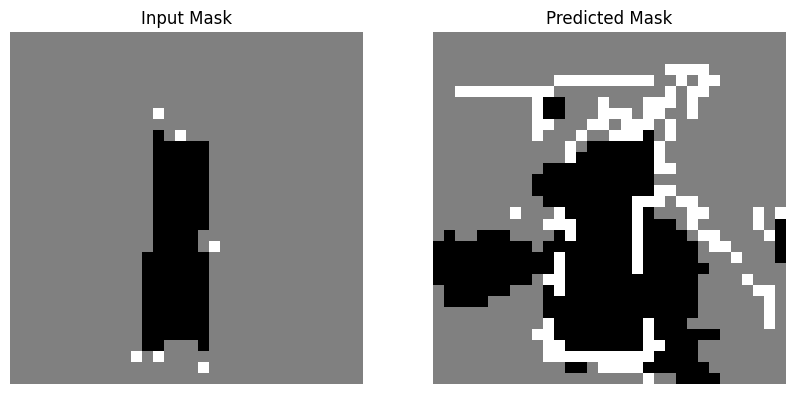

Epoch [41/75], Step [58/58], Loss: 0.571275532245636


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

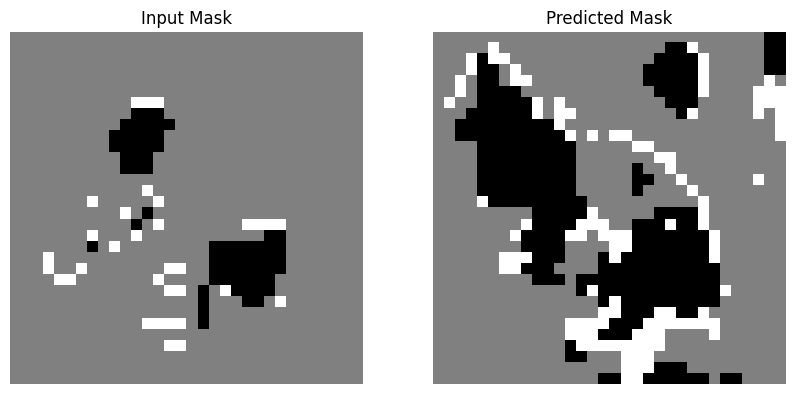

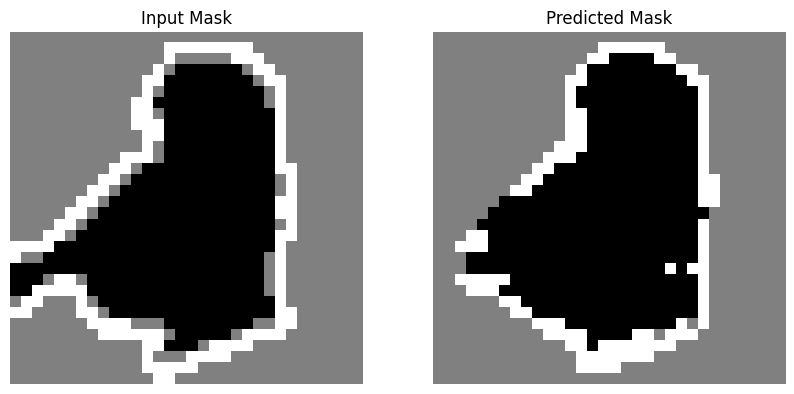

Epoch [42/75], Step [58/58], Loss: 0.5263082385063171


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

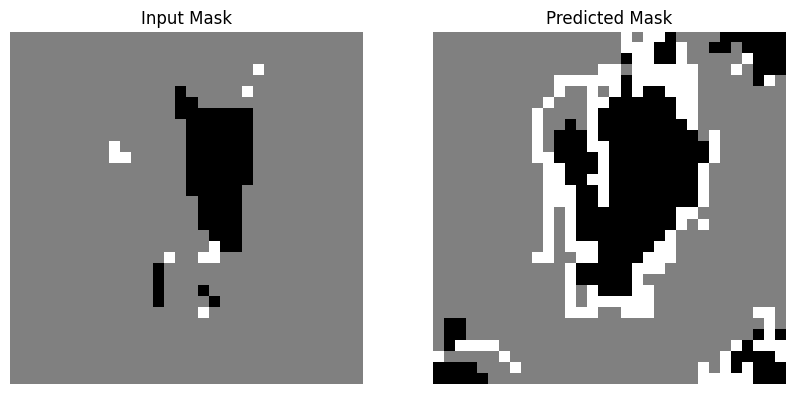

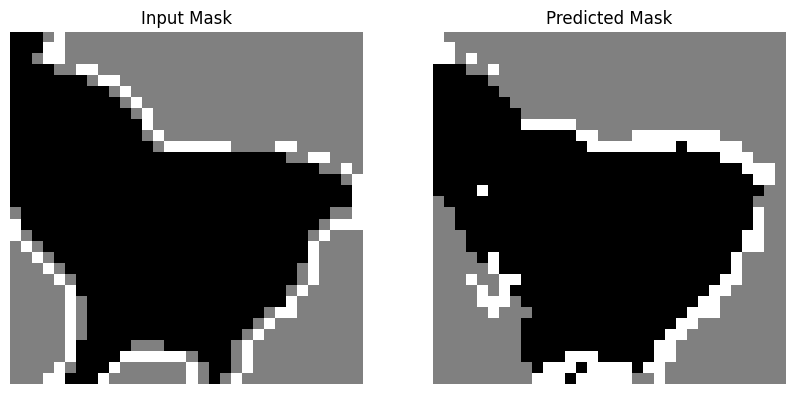

Epoch [43/75], Step [58/58], Loss: 0.5578246116638184


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

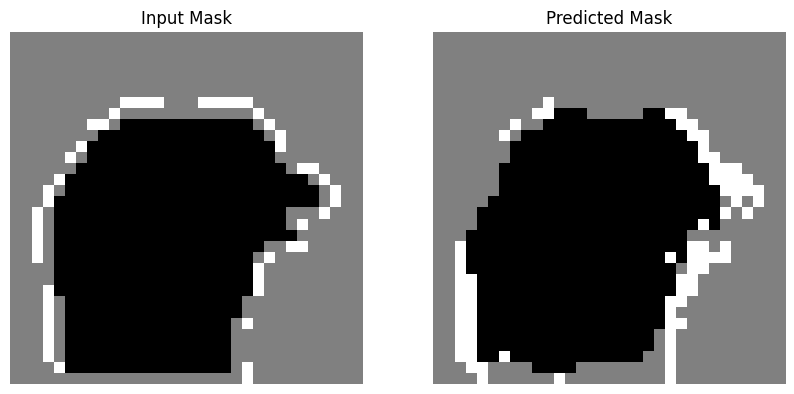

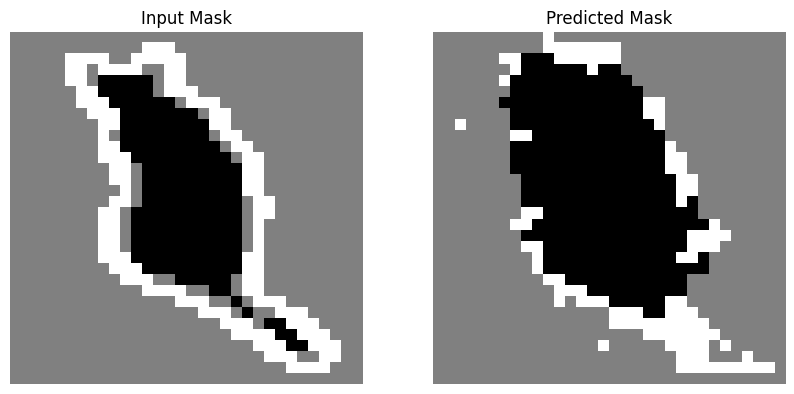

Epoch [44/75], Step [58/58], Loss: 0.5610017776489258


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

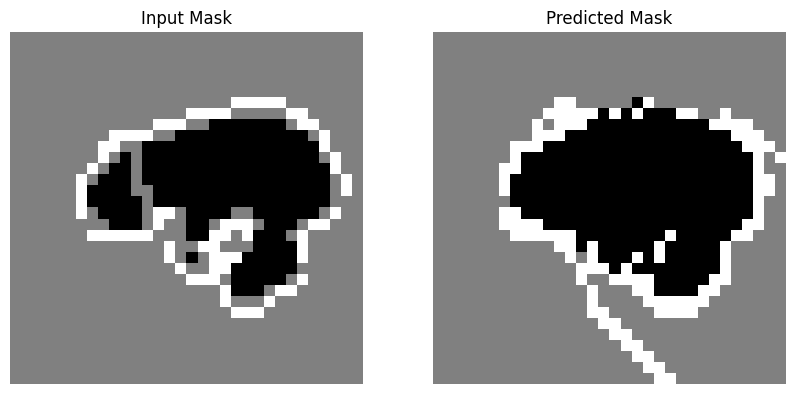

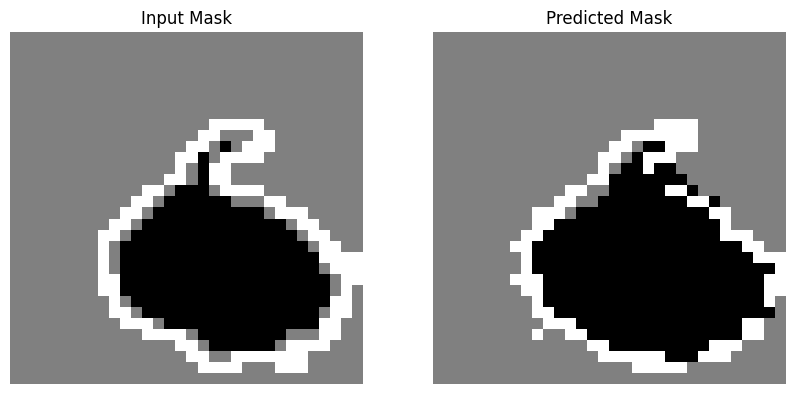

Epoch [45/75], Step [58/58], Loss: 0.5449637770652771


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

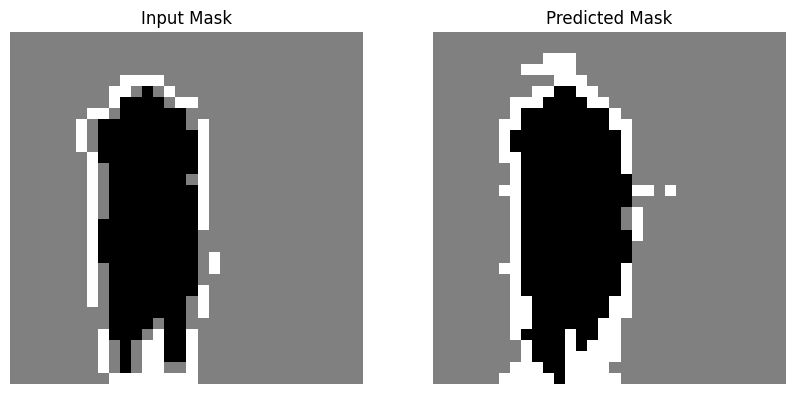

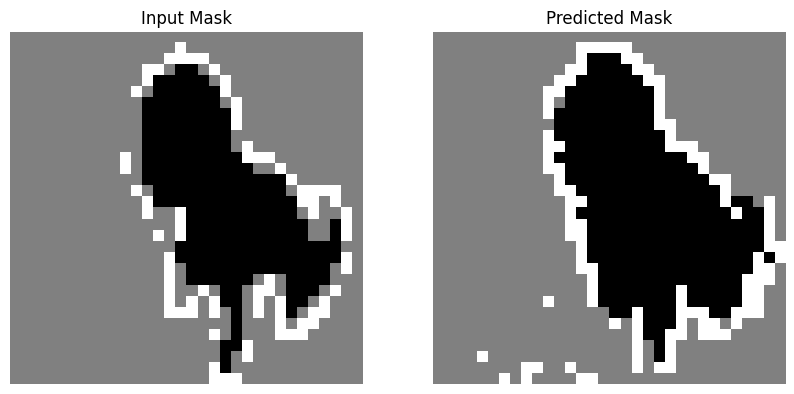

Epoch [46/75], Step [58/58], Loss: 0.5560520887374878


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

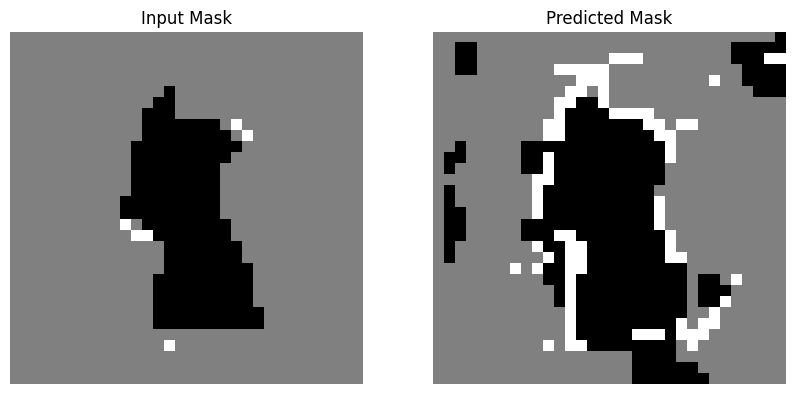

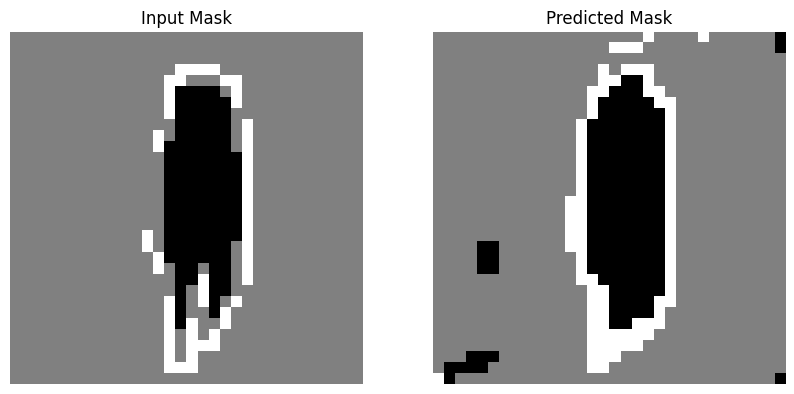

Epoch [47/75], Step [58/58], Loss: 0.5467529892921448


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

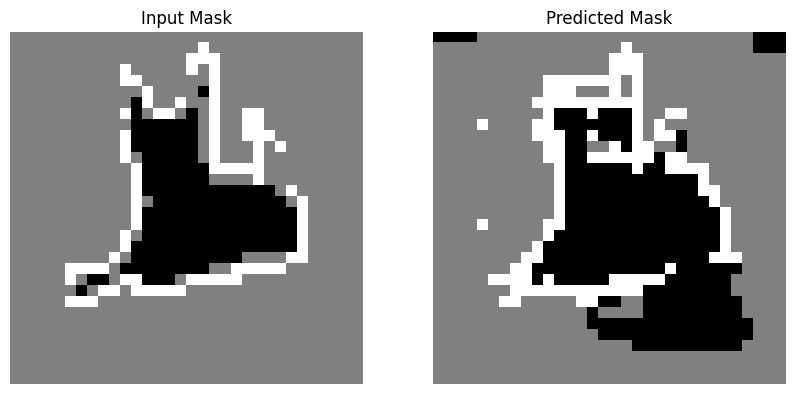

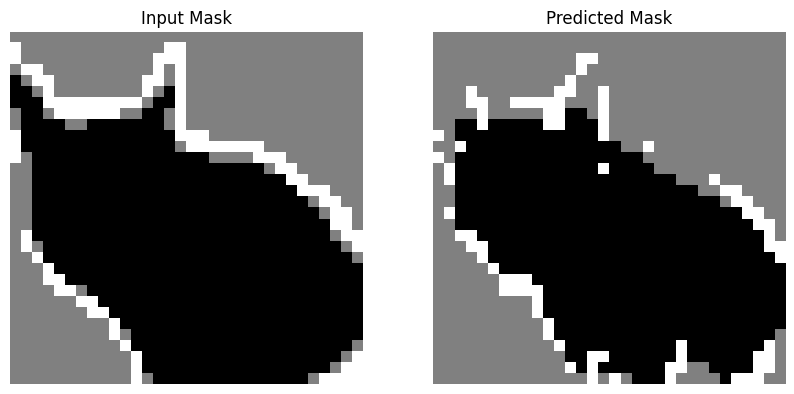

Epoch [48/75], Step [58/58], Loss: 0.5701700448989868


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

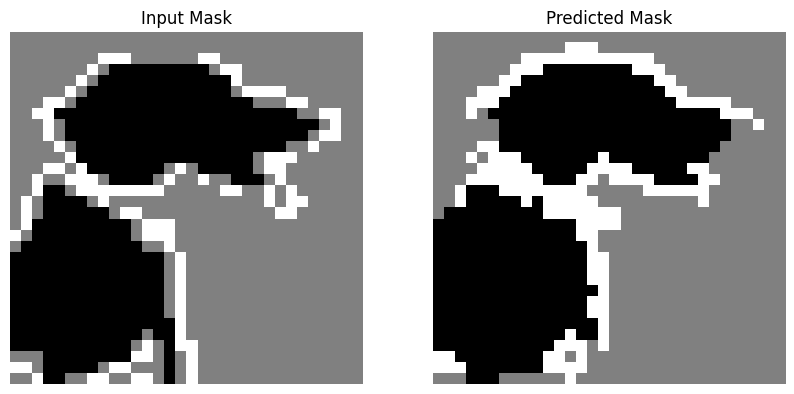

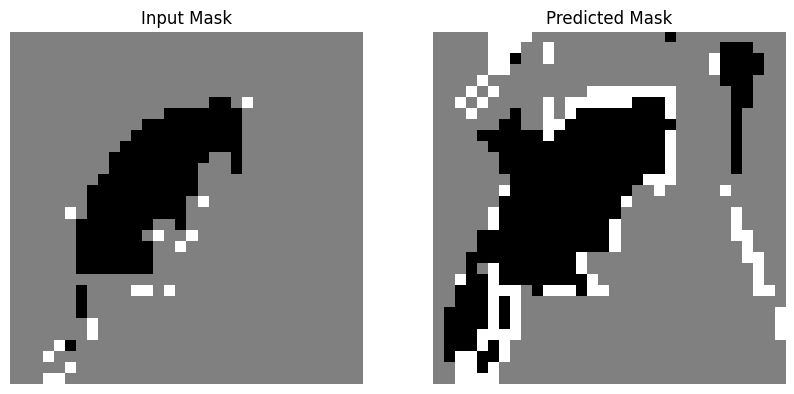

Epoch [49/75], Step [58/58], Loss: 0.5458397269248962


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

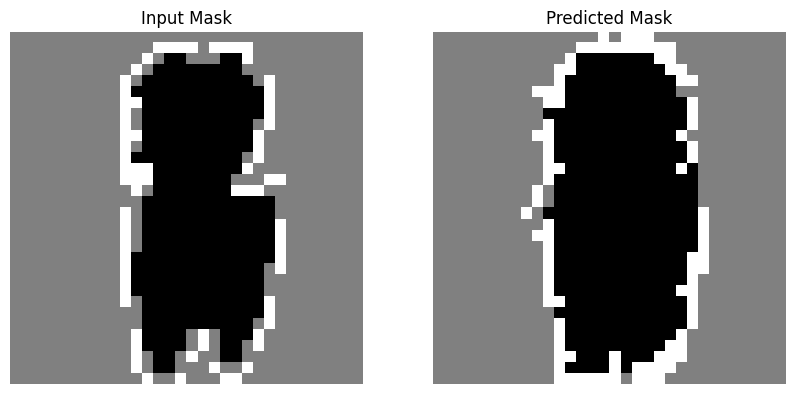

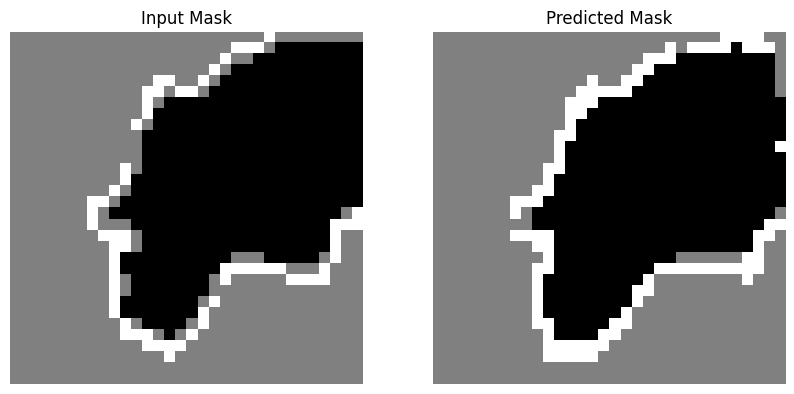

Epoch [50/75], Step [58/58], Loss: 0.540485143661499


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

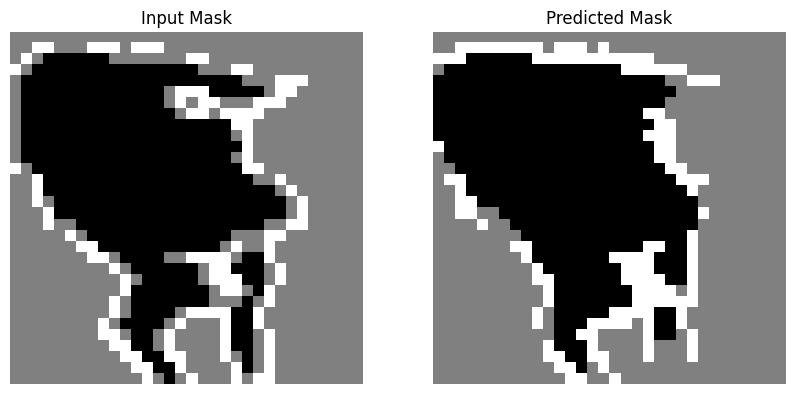

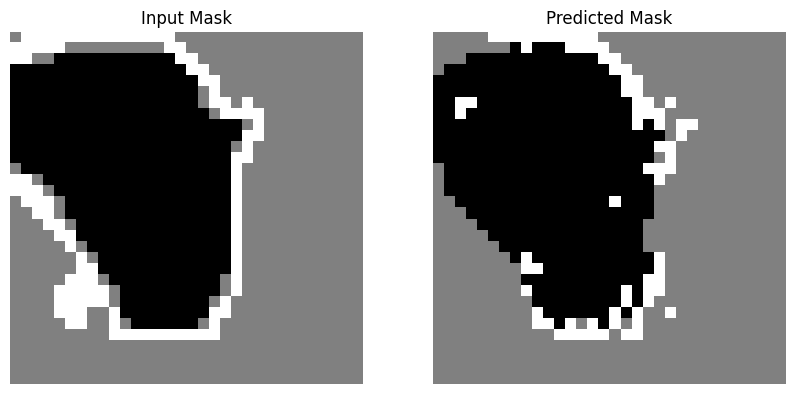

Epoch [51/75], Step [58/58], Loss: 0.5202398896217346


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

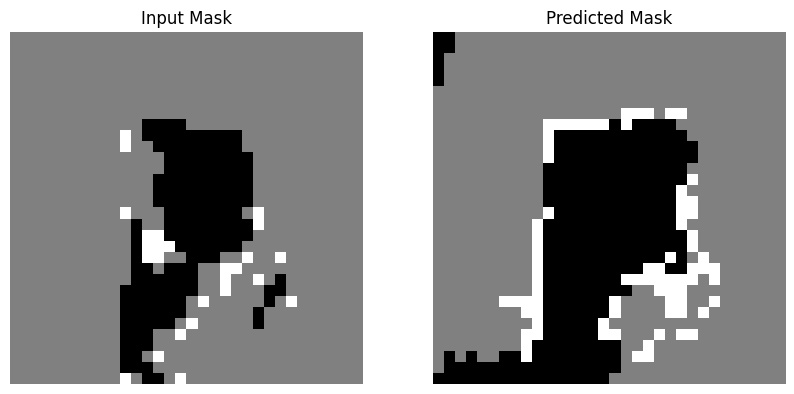

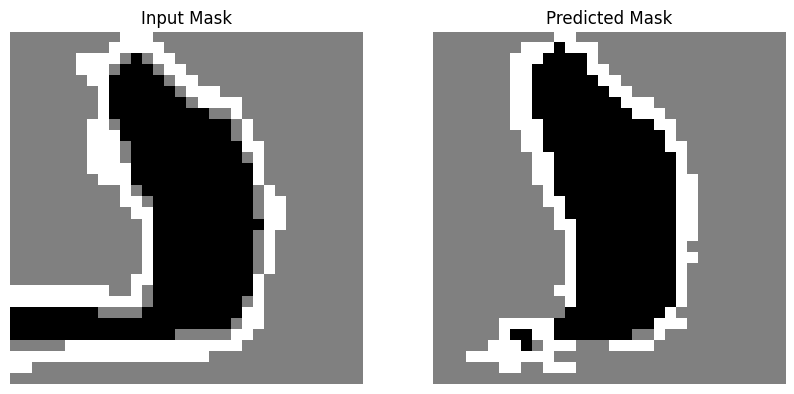

Epoch [52/75], Step [58/58], Loss: 0.5409660935401917


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

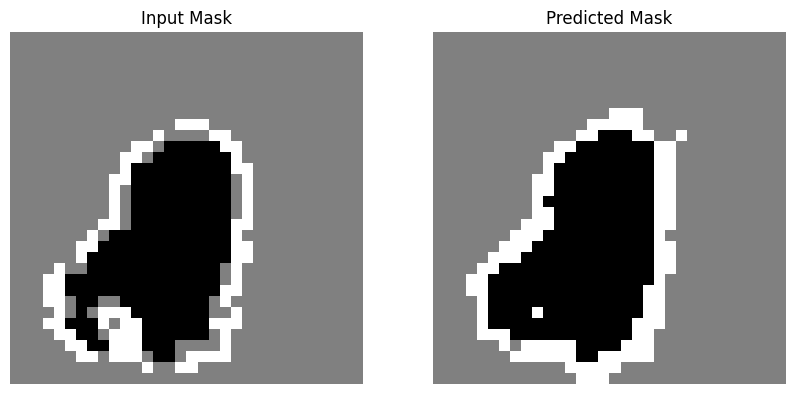

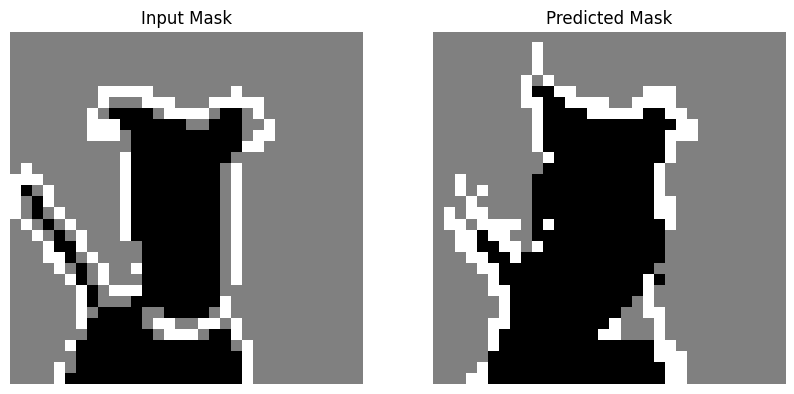

Epoch [53/75], Step [58/58], Loss: 0.5316383838653564


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

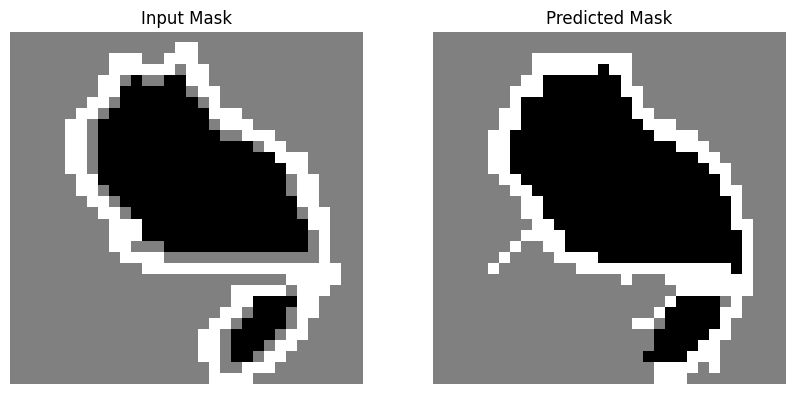

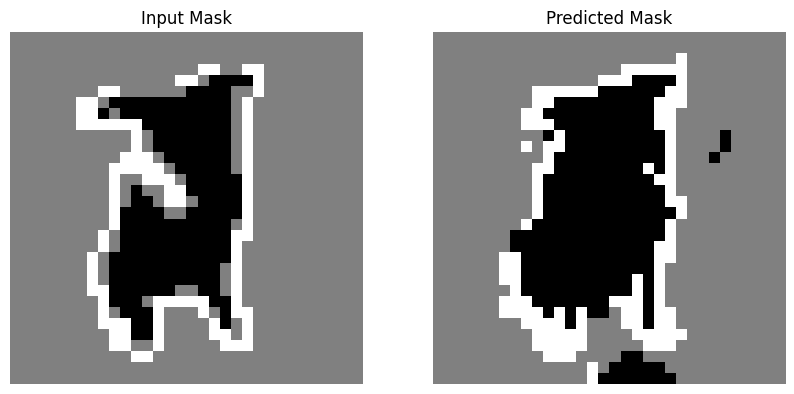

Epoch [54/75], Step [58/58], Loss: 0.5106458067893982


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

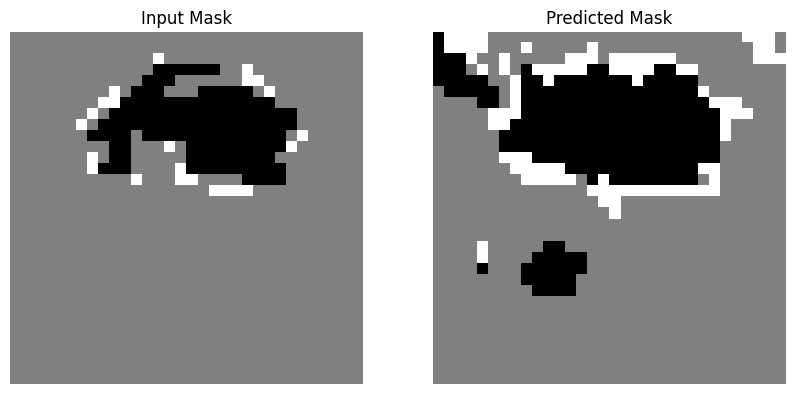

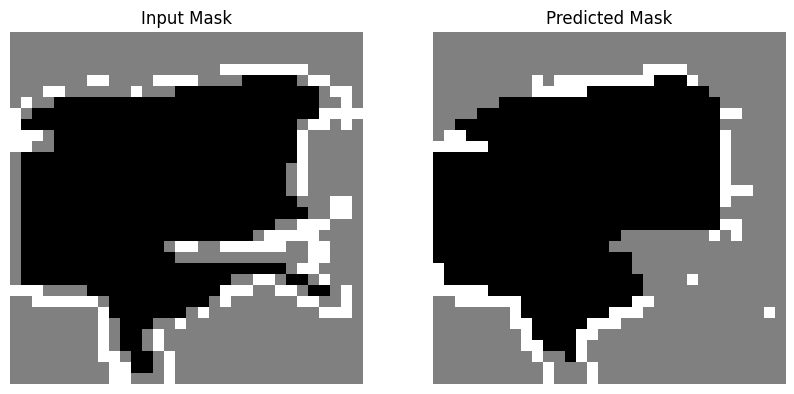

Epoch [55/75], Step [58/58], Loss: 0.537376344203949


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

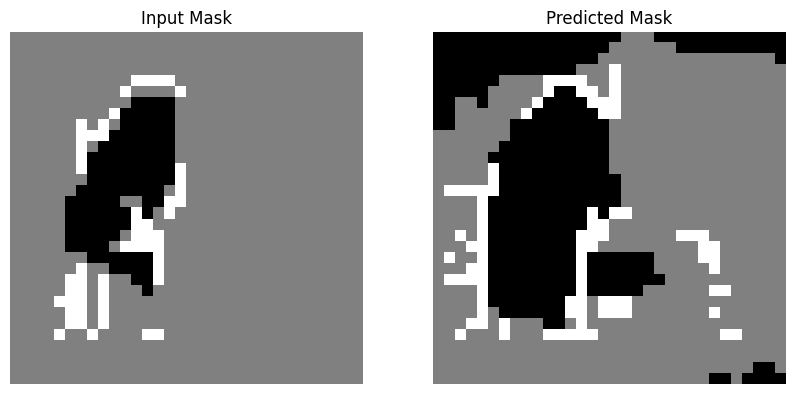

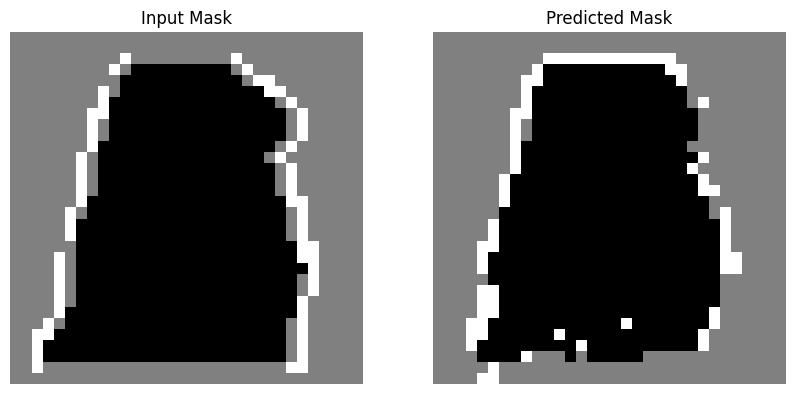

Epoch [56/75], Step [58/58], Loss: 0.557685911655426


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

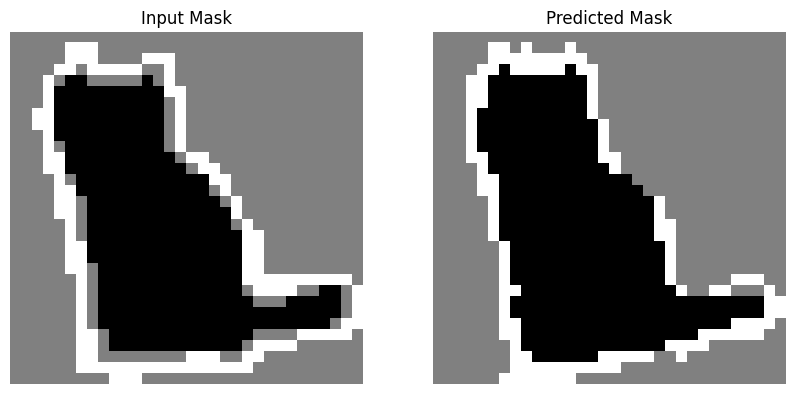

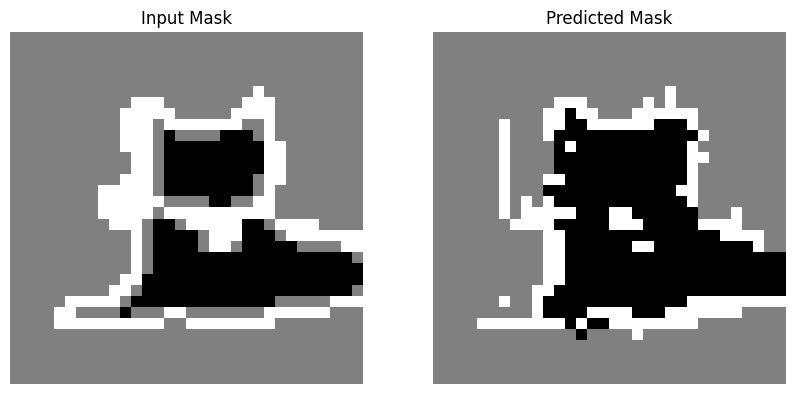

Epoch [57/75], Step [58/58], Loss: 0.52904212474823


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

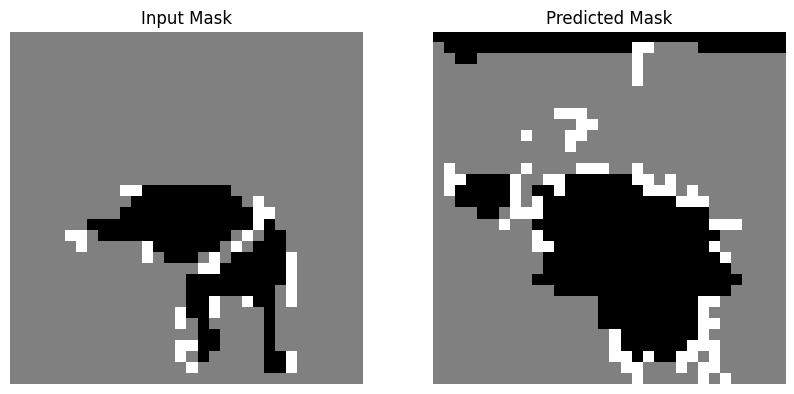

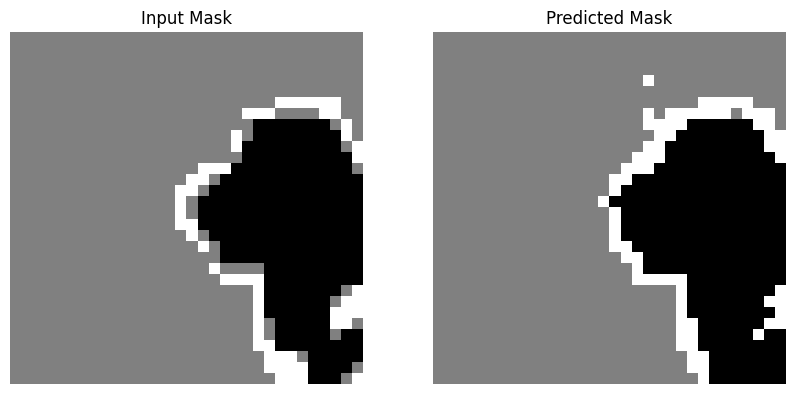

Epoch [58/75], Step [58/58], Loss: 0.510138213634491


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

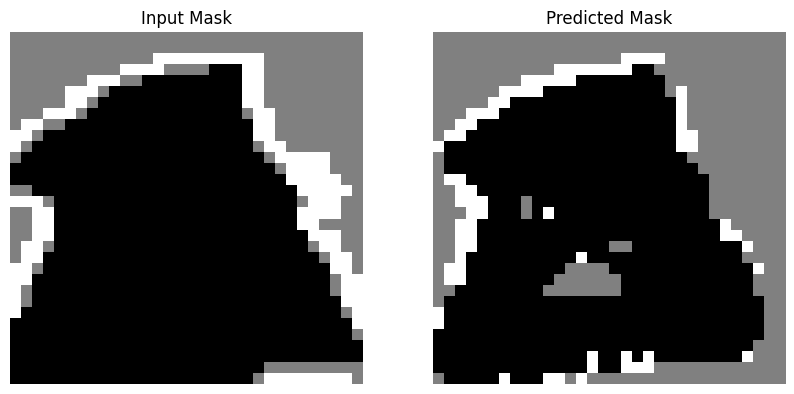

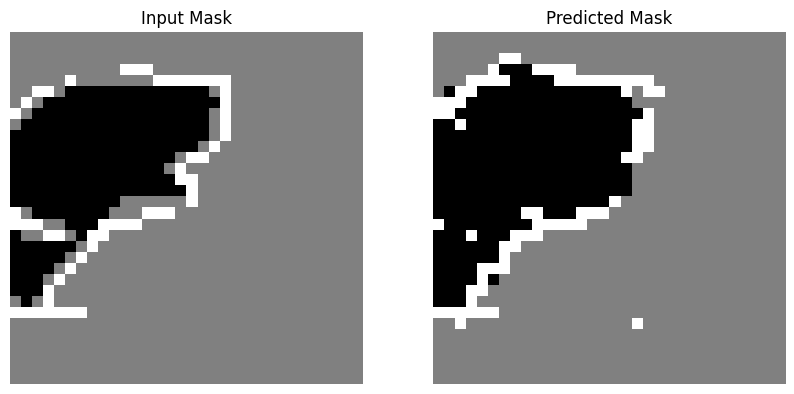

Epoch [59/75], Step [58/58], Loss: 0.5110360980033875


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

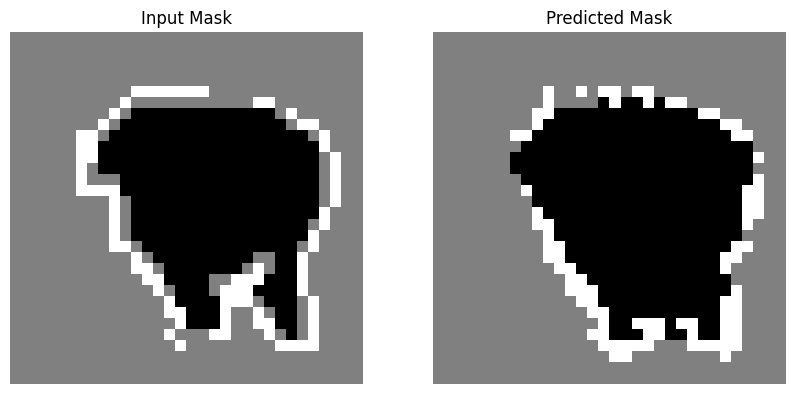

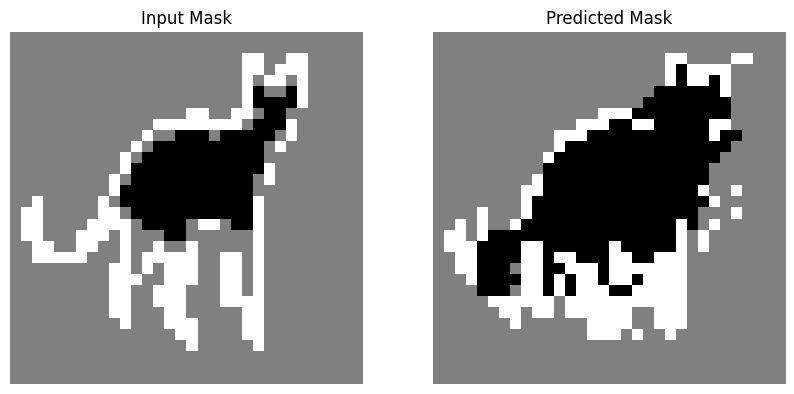

Epoch [60/75], Step [58/58], Loss: 0.5231656432151794


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

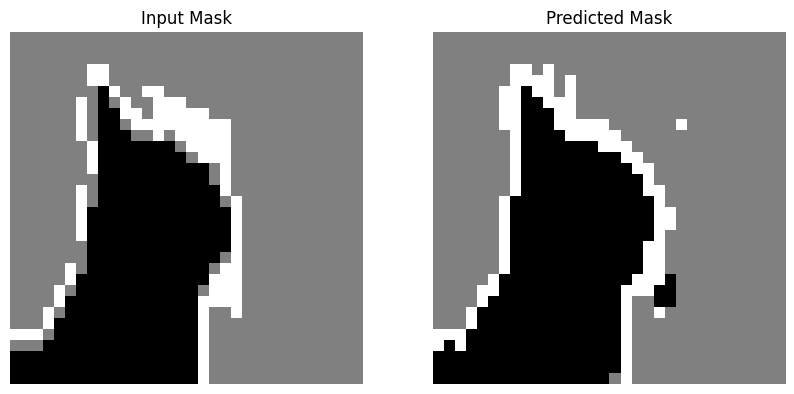

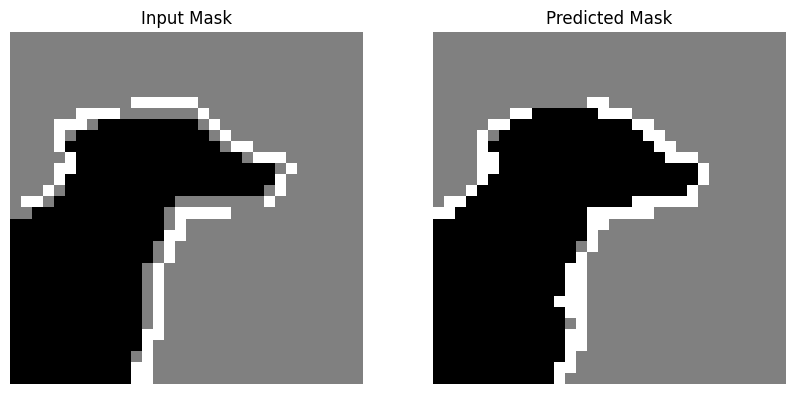

Epoch [61/75], Step [58/58], Loss: 0.5122506022453308


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

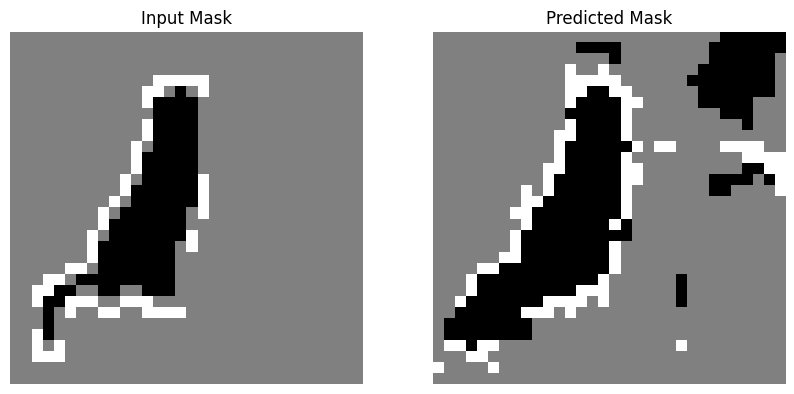

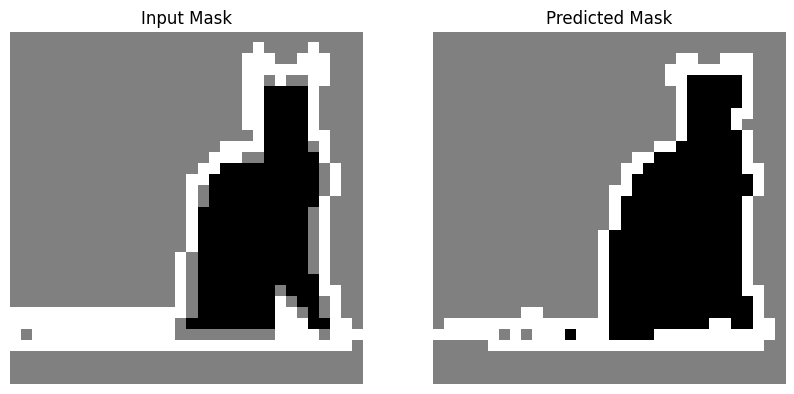

Epoch [62/75], Step [58/58], Loss: 0.5189903974533081


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

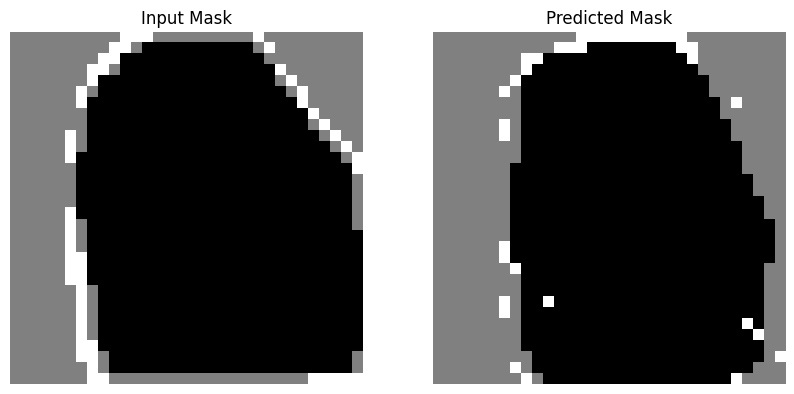

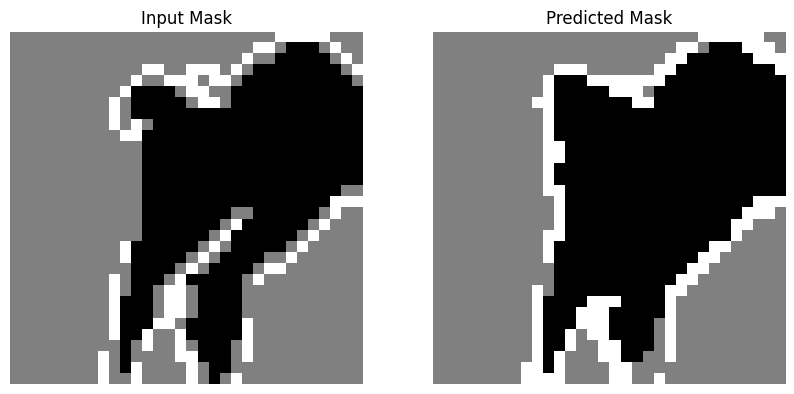

Epoch [63/75], Step [58/58], Loss: 0.5196888446807861


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

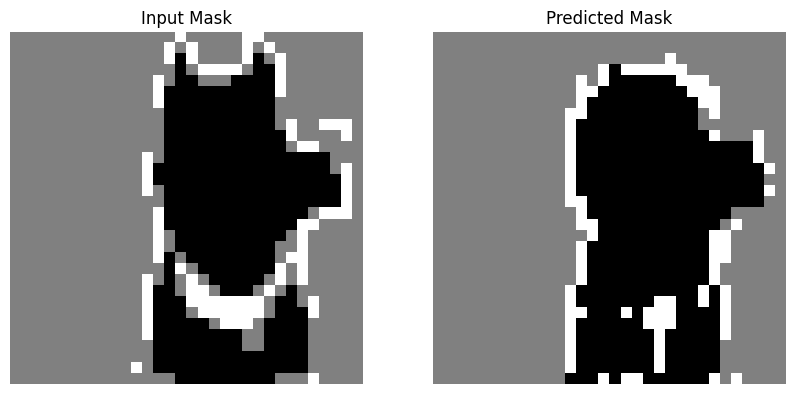

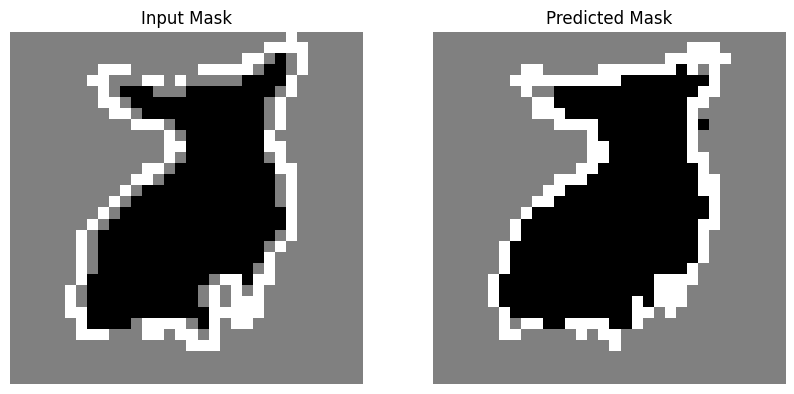

Epoch [64/75], Step [58/58], Loss: 0.495125949382782


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

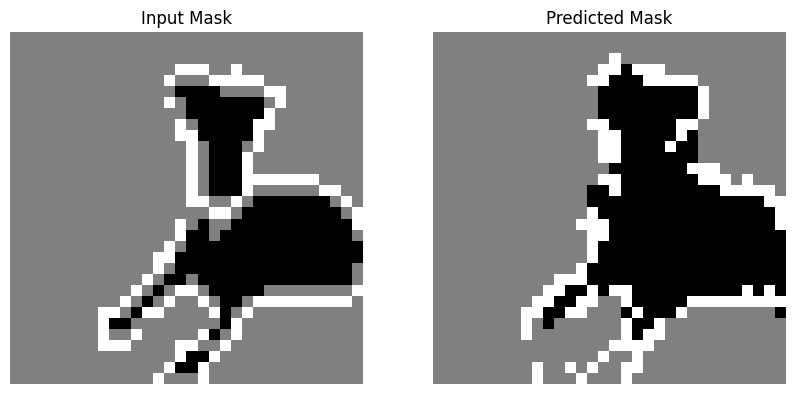

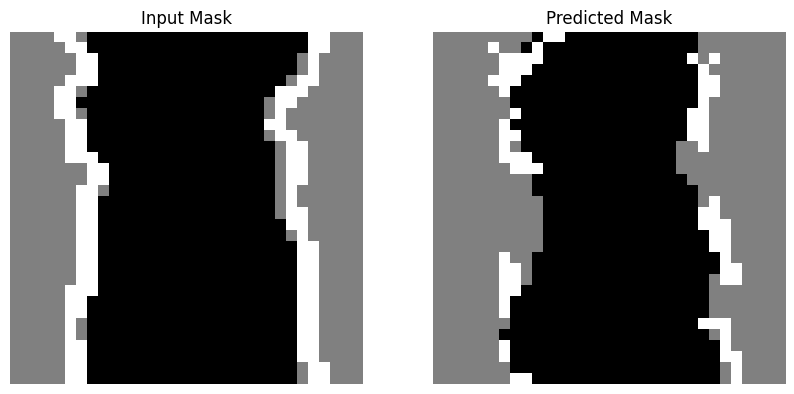

Epoch [65/75], Step [58/58], Loss: 0.5021913647651672


Steps:   0%|          | 0/58 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:


#model = Unet(in_channels = 3, out_channels = 3).to(device)
#model.apply(initialize_weights)
#optimizer = optim.SGD(model.parameters(), momentum = 0.99, lr = 0.0002, weight_decay = 1e-7)
optimizer = optim.Adam(model.parameters(), betas = (0.9,0.999), lr = 6e-5, weight_decay = 5e-4)
scheduler = StepLR(optimizer, step_size = 10, gamma = 0.8)


num_epochs = 75

l1_lambda = 0.000005

# criterion = nn.MSELoss()
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
criterion = compound_tversky_loss

for epoch in tqdm(range(num_epochs), desc = "Epochs"):
  for i, (images, masks) in enumerate(tqdm(train_loader, desc = "Steps", leave = False)):
    images = images.to(device)
    masks = masks.to(device)

    outputs = model(images)
    masks = masks.squeeze(1)
    loss = criterion(outputs, masks)

    # l1_reg = torch.tensor(0.).to(device)
    # for param in model.parameters():
    #   l1_reg += torch.norm(param, 1)
    # loss += l1_lambda * l1_reg

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  scheduler.step()
  sample_images(2)
  print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')